In [1]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Apr 13 23:06:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   49C    P2              57W / 250W |    796MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [5]:
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
env_id="MountainCar-v0"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_vec_env_sb3(env_id, n_envs=1)

print(env.action_space.n)
print(env.observation_space.shape[0])

(500000, 2) (500000,) (500000,) (500000,) (500000,) (500000, 2)
[-0.43945786  0.        ] 0 -1.0 False {'TimeLimit.truncated': False} [-0.44108224 -0.00162438]
3
2


In [6]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [11]:
policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)

nn.init.kaiming_normal_(policy_network.fc1.weight)
nn.init.kaiming_normal_(policy_network.fc2.weight)
nn.init.kaiming_normal_(policy_network.fc3.weight)
prev = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)
env=make_vec_env_sb3(env_id, n_envs=1)

# Training loop
num_epochs = 5
batch_size = 128

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//100
num_test = 10
prev_load_freq = 1000
now_log=0
now_pos=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        model_dist = Categorical(logits=logits)
        model_act_sample = model_dist.sample()
        policy_chosen_logps = model_dist.log_prob(act_batch)
        policy_rejected_logps = model_dist.log_prob(model_act_sample)
        with torch.no_grad():
            prev_dist = Categorical(logits=prev(obs_batch))
            reference_chosen_logps = prev_dist.log_prob(act_batch)
            reference_rejected_logps = prev_dist.log_prob(model_act_sample)


        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps


        beta = 1
        losses = (-F.logsigmoid(beta * logits))
        loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        if (step+1) % prev_load_freq == 0:
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./gif/"+image_path, frames)

            print(total_reward/num_test)
            eval_rewards.append(total_reward/num_test)
            policy_network.train()  # 切换回训练模式


         

env.close()

Epoch [1/5]:   0%|          | 0/3907 [00:00<?, ?it/s, loss=0.622, positive_reward=0.176, negative_reward=0.0162, margin=0.16] 

Epoch [1/5]:   2%|▏         | 70/3907 [00:05<05:15, 12.17it/s, loss=0.603, positive_reward=0.596, negative_reward=0.149, margin=0.447]  

[-200.]


Epoch [1/5]:   3%|▎         | 105/3907 [00:10<06:30,  9.73it/s, loss=0.596, positive_reward=0.754, negative_reward=0.25, margin=0.504] 

[-200.]


Epoch [1/5]:   4%|▎         | 140/3907 [00:16<07:08,  8.78it/s, loss=0.571, positive_reward=0.909, negative_reward=0.299, margin=0.61] 

[-200.]


Epoch [1/5]:   5%|▍         | 177/3907 [00:21<07:20,  8.48it/s, loss=0.508, positive_reward=0.875, negative_reward=0.171, margin=0.704]

[-200.]


Epoch [1/5]:   6%|▌         | 217/3907 [00:26<06:57,  8.83it/s, loss=0.552, positive_reward=0.799, negative_reward=0.226, margin=0.572]

[-200.]


Epoch [1/5]:   7%|▋         | 256/3907 [00:32<06:50,  8.90it/s, loss=0.5, positive_reward=1.04, negative_reward=0.216, margin=0.822]   

[-200.]


Epoch [1/5]:   8%|▊         | 296/3907 [00:37<06:35,  9.12it/s, loss=0.586, positive_reward=1.03, negative_reward=0.43, margin=0.601]  

[-200.]


Epoch [1/5]:   9%|▊         | 334/3907 [00:42<06:38,  8.97it/s, loss=0.545, positive_reward=0.914, negative_reward=0.329, margin=0.585]

[-200.]


Epoch [1/5]:  10%|▉         | 372/3907 [00:48<06:41,  8.81it/s, loss=0.562, positive_reward=0.893, negative_reward=0.316, margin=0.577]

[-200.]


Epoch [1/5]:  11%|█         | 413/3907 [00:53<06:24,  9.08it/s, loss=0.572, positive_reward=1.19, negative_reward=0.596, margin=0.596] 

[-200.]


Epoch [1/5]:  12%|█▏        | 452/3907 [00:58<06:11,  9.31it/s, loss=0.564, positive_reward=0.962, negative_reward=0.484, margin=0.478]

[-194.3]


Epoch [1/5]:  13%|█▎        | 491/3907 [01:03<06:10,  9.23it/s, loss=0.602, positive_reward=1.13, negative_reward=0.738, margin=0.395] 

[-192.8]


Epoch [1/5]:  14%|█▎        | 528/3907 [01:08<05:53,  9.56it/s, loss=0.529, positive_reward=1.14, negative_reward=0.431, margin=0.71] 

[-188.9]


Epoch [1/5]:  15%|█▍        | 567/3907 [01:13<06:03,  9.18it/s, loss=0.612, positive_reward=1.3, negative_reward=0.883, margin=0.42]  

[-188.4]


Epoch [1/5]:  16%|█▌        | 606/3907 [01:18<05:42,  9.64it/s, loss=0.637, positive_reward=1.33, negative_reward=0.885, margin=0.44] 

[-181.9]


Epoch [1/5]:  17%|█▋        | 645/3907 [01:23<05:49,  9.33it/s, loss=0.595, positive_reward=1.29, negative_reward=0.675, margin=0.618]

[-174.5]


Epoch [1/5]:  18%|█▊        | 687/3907 [01:28<05:31,  9.71it/s, loss=0.635, positive_reward=1.4, negative_reward=1.03, margin=0.372]  

[-177.]


Epoch [1/5]:  19%|█▊        | 726/3907 [01:33<05:33,  9.54it/s, loss=0.596, positive_reward=1.19, negative_reward=0.773, margin=0.413] 

[-184.9]


Epoch [1/5]:  19%|█▉        | 761/3907 [01:39<05:59,  8.76it/s, loss=0.629, positive_reward=1.28, negative_reward=0.865, margin=0.413]

[-171.9]


Epoch [1/5]:  21%|██        | 816/3907 [01:44<04:59, 10.33it/s, loss=0.61, positive_reward=1.23, negative_reward=0.809, margin=0.423] 

[-179.3]


Epoch [1/5]:  22%|██▏       | 849/3907 [01:49<05:34,  9.13it/s, loss=0.619, positive_reward=1.43, negative_reward=0.955, margin=0.478]

[-183.9]


Epoch [1/5]:  23%|██▎       | 883/3907 [01:54<05:54,  8.53it/s, loss=0.592, positive_reward=1.37, negative_reward=0.897, margin=0.472]

[-183.]


Epoch [1/5]:  24%|██▎       | 920/3907 [01:58<05:14,  9.50it/s, loss=0.628, positive_reward=1.33, negative_reward=0.977, margin=0.356]

[-168.2]


Epoch [1/5]:  24%|██▍       | 956/3907 [02:03<05:12,  9.45it/s, loss=0.583, positive_reward=1.48, negative_reward=0.867, margin=0.615]

[-175.8]


Epoch [1/5]:  26%|██▌       | 998/3907 [02:07<04:17, 11.31it/s, loss=0.678, positive_reward=0.0531, negative_reward=0.00215, margin=0.0509]   

[-152.9]


Epoch [1/5]:  27%|██▋       | 1037/3907 [02:10<03:46, 12.67it/s, loss=0.692, positive_reward=0.0992, negative_reward=0.0627, margin=0.0364]  

[-143.3]


Epoch [1/5]:  28%|██▊       | 1077/3907 [02:14<03:54, 12.07it/s, loss=0.693, positive_reward=0.113, negative_reward=0.0945, margin=0.0184]   

[-136.2]


Epoch [1/5]:  29%|██▊       | 1114/3907 [02:18<03:41, 12.59it/s, loss=0.693, positive_reward=0.126, negative_reward=0.0918, margin=0.0347]   

[-147.9]


Epoch [1/5]:  29%|██▉       | 1152/3907 [02:21<03:27, 13.26it/s, loss=0.666, positive_reward=0.11, negative_reward=0.0156, margin=0.0942]  

[-141.7]


Epoch [1/5]:  31%|███       | 1205/3907 [02:24<02:49, 15.90it/s, loss=0.695, positive_reward=0.103, negative_reward=0.0977, margin=0.00485] 

[-130.3]


Epoch [1/5]:  32%|███▏      | 1239/3907 [02:29<04:04, 10.90it/s, loss=0.687, positive_reward=0.108, negative_reward=0.0874, margin=0.0207]   

[-167.2]


Epoch [1/5]:  33%|███▎      | 1273/3907 [02:32<03:28, 12.65it/s, loss=0.683, positive_reward=0.0928, negative_reward=0.0627, margin=0.0301] 

[-139.4]


Epoch [1/5]:  34%|███▎      | 1311/3907 [02:35<03:12, 13.45it/s, loss=0.693, positive_reward=0.139, negative_reward=0.121, margin=0.0175]  

[-119.4]


Epoch [1/5]:  35%|███▍      | 1349/3907 [02:39<03:28, 12.28it/s, loss=0.704, positive_reward=0.175, negative_reward=0.168, margin=0.00758]  

[-149.8]


Epoch [1/5]:  36%|███▌      | 1388/3907 [02:43<03:26, 12.18it/s, loss=0.659, positive_reward=0.143, negative_reward=-.000515, margin=0.144] 

[-132.8]


Epoch [1/5]:  37%|███▋      | 1428/3907 [02:48<03:49, 10.82it/s, loss=0.673, positive_reward=0.109, negative_reward=0.0327, margin=0.0762]  

[-124.9]


Epoch [1/5]:  38%|███▊      | 1468/3907 [02:51<03:08, 12.91it/s, loss=0.685, positive_reward=0.134, negative_reward=0.101, margin=0.0327]  

[-115.4]


Epoch [1/5]:  39%|███▊      | 1507/3907 [02:54<02:50, 14.09it/s, loss=0.671, positive_reward=0.166, negative_reward=0.103, margin=0.0636]  

[-115.3]


Epoch [1/5]:  40%|███▉      | 1546/3907 [02:57<02:43, 14.48it/s, loss=0.688, positive_reward=0.137, negative_reward=0.118, margin=0.019]   

[-127.7]


Epoch [1/5]:  40%|████      | 1582/3907 [03:01<02:45, 14.02it/s, loss=0.677, positive_reward=0.126, negative_reward=0.0805, margin=0.0456]  

[-149.]


Epoch [1/5]:  42%|████▏     | 1622/3907 [03:07<04:05,  9.31it/s, loss=0.681, positive_reward=0.127, negative_reward=0.0744, margin=0.0524]

[-129.1]


Epoch [1/5]:  42%|████▏     | 1660/3907 [03:11<03:18, 11.33it/s, loss=0.679, positive_reward=0.144, negative_reward=0.0852, margin=0.0585] 

[-122.1]


Epoch [1/5]:  44%|████▍     | 1711/3907 [03:15<02:55, 12.50it/s, loss=0.679, positive_reward=0.19, negative_reward=0.142, margin=0.0488]  

[-141.7]


Epoch [1/5]:  45%|████▍     | 1743/3907 [03:18<02:50, 12.68it/s, loss=0.676, positive_reward=0.144, negative_reward=0.0956, margin=0.0484]

[-115.4]


Epoch [1/5]:  46%|████▌     | 1778/3907 [03:21<02:42, 13.07it/s, loss=0.691, positive_reward=0.109, negative_reward=0.0945, margin=0.0148] 

[-124.9]


Epoch [1/5]:  47%|████▋     | 1817/3907 [03:25<02:40, 13.04it/s, loss=0.68, positive_reward=0.119, negative_reward=0.0695, margin=0.049]    

[-128.2]


Epoch [1/5]:  47%|████▋     | 1854/3907 [03:27<02:19, 14.67it/s, loss=0.671, positive_reward=0.134, negative_reward=0.0567, margin=0.0774]

[-112.1]


Epoch [1/5]:  49%|████▉     | 1907/3907 [03:32<02:50, 11.71it/s, loss=0.666, positive_reward=0.156, negative_reward=0.0743, margin=0.0815]

[-158.6]


Epoch [1/5]:  50%|████▉     | 1941/3907 [03:36<02:38, 12.41it/s, loss=0.697, positive_reward=0.0999, negative_reward=0.0953, margin=0.00467]

[-129.1]


Epoch [1/5]:  50%|█████     | 1973/3907 [03:39<02:30, 12.88it/s, loss=0.666, positive_reward=0.177, negative_reward=0.0972, margin=0.0793]  

[-134.1]


Epoch [1/5]:  51%|█████▏    | 2012/3907 [03:44<02:59, 10.53it/s, loss=0.699, positive_reward=-.00988, negative_reward=-.00939, margin=-.000491] 

[-140.4]


Epoch [1/5]:  53%|█████▎    | 2060/3907 [03:47<02:18, 13.29it/s, loss=0.693, positive_reward=0.0191, negative_reward=0.0136, margin=0.00544]   

[-105.6]


Epoch [1/5]:  53%|█████▎    | 2090/3907 [03:50<02:23, 12.63it/s, loss=0.683, positive_reward=0.0204, negative_reward=-.00727, margin=0.0277]  

[-103.3]


Epoch [1/5]:  55%|█████▍    | 2141/3907 [03:53<01:50, 15.98it/s, loss=0.691, positive_reward=0.0358, negative_reward=0.0305, margin=0.00529]   

[-111.3]


Epoch [1/5]:  56%|█████▌    | 2173/3907 [03:56<02:02, 14.16it/s, loss=0.683, positive_reward=0.0258, negative_reward=-.00764, margin=0.0334]   

[-132.9]


Epoch [1/5]:  56%|█████▋    | 2206/3907 [04:00<02:09, 13.11it/s, loss=0.685, positive_reward=0.0225, negative_reward=0.00338, margin=0.0191] 

[-125.3]


Epoch [1/5]:  58%|█████▊    | 2259/3907 [04:03<01:45, 15.64it/s, loss=0.688, positive_reward=0.0378, negative_reward=0.0227, margin=0.015]    

[-117.7]


Epoch [1/5]:  59%|█████▊    | 2292/3907 [04:06<01:52, 14.38it/s, loss=0.711, positive_reward=-.00176, negative_reward=0.0271, margin=-.0289]  

[-115.4]


Epoch [1/5]:  60%|█████▉    | 2326/3907 [04:09<01:46, 14.87it/s, loss=0.69, positive_reward=0.0199, negative_reward=0.00208, margin=0.0179]   

[-100.2]


Epoch [1/5]:  61%|██████    | 2366/3907 [04:11<01:34, 16.26it/s, loss=0.695, positive_reward=0.0182, negative_reward=0.00524, margin=0.0129] 

[-104.]


Epoch [1/5]:  61%|██████▏   | 2402/3907 [04:14<01:36, 15.62it/s, loss=0.691, positive_reward=0.0214, negative_reward=0.0148, margin=0.00663] 

[-111.4]


Epoch [1/5]:  62%|██████▏   | 2441/3907 [04:17<01:31, 16.02it/s, loss=0.678, positive_reward=0.0445, negative_reward=0.00208, margin=0.0424] 

[-137.6]


Epoch [1/5]:  63%|██████▎   | 2480/3907 [04:20<01:29, 15.98it/s, loss=0.698, positive_reward=0.0236, negative_reward=0.0246, margin=-.000973]

[-116.6]


Epoch [1/5]:  65%|██████▍   | 2532/3907 [04:23<01:15, 18.12it/s, loss=0.695, positive_reward=0.0256, negative_reward=0.0228, margin=0.00283]   

[-119.]


Epoch [1/5]:  66%|██████▌   | 2563/3907 [04:26<01:38, 13.71it/s, loss=0.692, positive_reward=0.0174, negative_reward=0.0128, margin=0.00457] 

[-125.7]


Epoch [1/5]:  66%|██████▋   | 2594/3907 [04:30<01:48, 12.09it/s, loss=0.711, positive_reward=0.00393, negative_reward=0.0336, margin=-.0297]   

[-112.9]


Epoch [1/5]:  68%|██████▊   | 2643/3907 [04:33<01:31, 13.86it/s, loss=0.693, positive_reward=0.0227, negative_reward=0.0103, margin=0.0124]   

[-114.9]


Epoch [1/5]:  69%|██████▊   | 2678/3907 [04:36<01:27, 14.11it/s, loss=0.704, positive_reward=0.0292, negative_reward=0.0457, margin=-.0166]  

[-109.4]


Epoch [1/5]:  70%|██████▉   | 2717/3907 [04:39<01:20, 14.78it/s, loss=0.697, positive_reward=0.0336, negative_reward=0.0347, margin=-.00115]  

[-103.2]


Epoch [1/5]:  70%|███████   | 2754/3907 [04:43<01:24, 13.66it/s, loss=0.683, positive_reward=0.0459, negative_reward=-.00674, margin=0.0526] 

[-132.4]


Epoch [1/5]:  72%|███████▏  | 2807/3907 [04:46<01:10, 15.69it/s, loss=0.68, positive_reward=0.0429, negative_reward=0.0037, margin=0.0392]   

[-111.3]


Epoch [1/5]:  73%|███████▎  | 2841/3907 [04:49<01:11, 14.97it/s, loss=0.69, positive_reward=0.0401, negative_reward=0.0263, margin=0.0138]   

[-106.9]


Epoch [1/5]:  74%|███████▎  | 2875/3907 [04:52<01:05, 15.68it/s, loss=0.68, positive_reward=0.026, negative_reward=-.0106, margin=0.0366]    

[-103.]


Epoch [1/5]:  75%|███████▍  | 2913/3907 [04:55<01:03, 15.67it/s, loss=0.695, positive_reward=0.0284, negative_reward=-.00409, margin=0.0325] 

[-114.7]


Epoch [1/5]:  76%|███████▌  | 2952/3907 [04:57<00:59, 16.12it/s, loss=0.688, positive_reward=0.0413, negative_reward=0.0266, margin=0.0147]   

[-104.6]


Epoch [1/5]:  77%|███████▋  | 2990/3907 [05:00<00:57, 15.97it/s, loss=0.694, positive_reward=-.000728, negative_reward=0.00133, margin=-.00206]

[-110.4]


Epoch [1/5]:  77%|███████▋  | 3026/3907 [05:03<00:59, 14.86it/s, loss=0.76, positive_reward=-.0233, negative_reward=0.0648, margin=-.0881]     

[-113.3]


Epoch [1/5]:  79%|███████▊  | 3069/3907 [05:06<00:51, 16.18it/s, loss=0.692, positive_reward=0.0159, negative_reward=0.00834, margin=0.00759]  

[-119.3]


Epoch [1/5]:  80%|███████▉  | 3108/3907 [05:09<00:48, 16.44it/s, loss=0.691, positive_reward=0.00964, negative_reward=-.000873, margin=0.0105] 

[-104.8]


Epoch [1/5]:  81%|████████  | 3147/3907 [05:12<00:45, 16.64it/s, loss=0.701, positive_reward=0.00149, negative_reward=0.00609, margin=-.0046]  

[-104.6]


Epoch [1/5]:  82%|████████▏ | 3187/3907 [05:15<00:44, 16.34it/s, loss=0.696, positive_reward=0.00114, negative_reward=0.00219, margin=-.00105] 

[-102.8]


Epoch [1/5]:  83%|████████▎ | 3225/3907 [05:18<00:42, 15.94it/s, loss=0.697, positive_reward=0.00507, negative_reward=0.00377, margin=0.0013]  

[-113.8]


Epoch [1/5]:  84%|████████▎ | 3265/3907 [05:21<00:36, 17.46it/s, loss=0.712, positive_reward=0.000363, negative_reward=0.0303, margin=-.03]    

[-97.5]


Epoch [1/5]:  85%|████████▍ | 3303/3907 [05:24<00:36, 16.45it/s, loss=0.692, positive_reward=0.00132, negative_reward=-.00616, margin=0.00748] 

[-112.5]


Epoch [1/5]:  86%|████████▌ | 3343/3907 [05:27<00:34, 16.52it/s, loss=0.688, positive_reward=0.00376, negative_reward=-.0242, margin=0.028]    

[-105.]


Epoch [1/5]:  87%|████████▋ | 3382/3907 [05:30<00:32, 16.38it/s, loss=0.697, positive_reward=0.0184, negative_reward=0.0198, margin=-.00144]   

[-112.]


Epoch [1/5]:  88%|████████▊ | 3421/3907 [05:32<00:29, 16.56it/s, loss=0.689, positive_reward=0.00545, negative_reward=-.00418, margin=0.00963] 

[-105.3]


Epoch [1/5]:  89%|████████▊ | 3458/3907 [05:35<00:28, 15.59it/s, loss=0.706, positive_reward=0.00302, negative_reward=0.0259, margin=-.0228]   

[-108.6]


Epoch [1/5]:  89%|████████▉ | 3496/3907 [05:39<00:27, 15.02it/s, loss=0.685, positive_reward=-.00247, negative_reward=-.021, margin=0.0185]    

[-109.4]


Epoch [1/5]:  91%|█████████ | 3550/3907 [05:42<00:21, 16.80it/s, loss=0.702, positive_reward=0.0125, negative_reward=0.021, margin=-.00855]   

[-103.3]


Epoch [1/5]:  92%|█████████▏| 3584/3907 [05:45<00:21, 14.72it/s, loss=0.681, positive_reward=0.0105, negative_reward=-.0182, margin=0.0287]    

[-101.7]


Epoch [1/5]:  93%|█████████▎| 3619/3907 [05:48<00:19, 14.82it/s, loss=0.688, positive_reward=0.014, negative_reward=0.00238, margin=0.0116]    

[-100.3]


Epoch [1/5]:  93%|█████████▎| 3653/3907 [05:51<00:17, 14.41it/s, loss=0.702, positive_reward=0.00332, negative_reward=0.0121, margin=-.00876]  

[-104.6]


Epoch [1/5]:  95%|█████████▍| 3693/3907 [05:54<00:13, 15.64it/s, loss=0.689, positive_reward=0.00618, negative_reward=-.0064, margin=0.0126]   

[-105.4]


Epoch [1/5]:  95%|█████████▌| 3729/3907 [05:56<00:11, 15.64it/s, loss=0.684, positive_reward=0.0183, negative_reward=-.00426, margin=0.0226]   

[-107.4]


Epoch [1/5]:  97%|█████████▋| 3779/3907 [05:59<00:06, 18.60it/s, loss=0.693, positive_reward=0.00707, negative_reward=0.00401, margin=0.00306] 

[-98.3]


Epoch [1/5]:  98%|█████████▊| 3811/3907 [06:02<00:06, 15.04it/s, loss=0.695, positive_reward=0.0116, negative_reward=0.00706, margin=0.00457] 

[-107.9]


Epoch [1/5]:  99%|█████████▊| 3849/3907 [06:05<00:03, 15.18it/s, loss=0.713, positive_reward=0.017, negative_reward=0.0404, margin=-.0235]    

[-104.9]


Epoch [1/5]: 100%|█████████▉| 3889/3907 [06:08<00:01, 15.92it/s, loss=0.719, positive_reward=-.0215, negative_reward=0.0123, margin=-.0337]    

[-99.8]


Epoch [1/5]: 100%|██████████| 3907/3907 [06:11<00:00, 10.50it/s, loss=0.719, positive_reward=-.0192, negative_reward=0.0119, margin=-.0311]


[-110.5]


Epoch [2/5]:   2%|▏         | 71/3907 [00:04<04:07, 15.47it/s, loss=0.719, positive_reward=0.00326, negative_reward=0.0224, margin=-.0192]    

[-106.8]


Epoch [2/5]:   3%|▎         | 103/3907 [00:07<04:34, 13.85it/s, loss=0.701, positive_reward=0.00996, negative_reward=0.0154, margin=-.0054]   

[-105.1]


Epoch [2/5]:   3%|▎         | 136/3907 [00:10<04:47, 13.13it/s, loss=0.701, positive_reward=0.0179, negative_reward=0.0201, margin=-.00222]   

[-113.3]


Epoch [2/5]:   5%|▍         | 188/3907 [00:13<04:10, 14.85it/s, loss=0.692, positive_reward=0.0149, negative_reward=-.00298, margin=0.0178]   

[-109.4]


Epoch [2/5]:   6%|▌         | 219/3907 [00:16<04:24, 13.92it/s, loss=0.69, positive_reward=0.0221, negative_reward=0.0061, margin=0.016]     

[-99.8]


Epoch [2/5]:   7%|▋         | 256/3907 [00:19<04:10, 14.60it/s, loss=0.717, positive_reward=-.00252, negative_reward=0.032, margin=-.0345]    

[-104.1]


Epoch [2/5]:   8%|▊         | 294/3907 [00:22<03:59, 15.06it/s, loss=0.688, positive_reward=0.0203, negative_reward=-.00461, margin=0.0249]   

[-104.6]


Epoch [2/5]:   9%|▊         | 335/3907 [00:25<03:31, 16.91it/s, loss=0.698, positive_reward=0.0112, negative_reward=0.0176, margin=-.00638]   

[-107.6]


Epoch [2/5]:  10%|▉         | 372/3907 [00:28<03:47, 15.53it/s, loss=0.696, positive_reward=0.0138, negative_reward=0.0164, margin=-.00259]   

[-103.8]


Epoch [2/5]:  11%|█         | 412/3907 [00:31<03:41, 15.80it/s, loss=0.7, positive_reward=0.0102, negative_reward=0.0196, margin=-.00936]      

[-102.3]


Epoch [2/5]:  11%|█▏        | 448/3907 [00:34<03:51, 14.93it/s, loss=0.684, positive_reward=0.0293, negative_reward=0.0019, margin=0.0274]    

[-98.]


Epoch [2/5]:  13%|█▎        | 502/3907 [00:37<03:21, 16.87it/s, loss=0.696, positive_reward=0.00265, negative_reward=0.0075, margin=-.00485]  

[-104.3]


Epoch [2/5]:  14%|█▎        | 536/3907 [00:41<03:55, 14.34it/s, loss=0.691, positive_reward=0.0218, negative_reward=0.0107, margin=0.0111]    

[-110.1]


Epoch [2/5]:  14%|█▍        | 566/3907 [00:44<04:15, 13.07it/s, loss=0.68, positive_reward=0.0147, negative_reward=-.0198, margin=0.0344]     

[-101.8]


Epoch [2/5]:  16%|█▌        | 615/3907 [00:47<03:40, 14.96it/s, loss=0.693, positive_reward=0.0225, negative_reward=0.0192, margin=0.00325]   

[-115.9]


Epoch [2/5]:  17%|█▋        | 646/3907 [00:50<03:56, 13.79it/s, loss=0.691, positive_reward=0.0172, negative_reward=0.00982, margin=0.00738] 

[-109.]


Epoch [2/5]:  18%|█▊        | 686/3907 [00:53<03:36, 14.88it/s, loss=0.702, positive_reward=0.00734, negative_reward=0.0181, margin=-.0108]  

[-102.1]


Epoch [2/5]:  19%|█▊        | 724/3907 [00:56<03:26, 15.39it/s, loss=0.703, positive_reward=0.0182, negative_reward=0.0229, margin=-.00475]   

[-106.1]


Epoch [2/5]:  20%|█▉        | 764/3907 [00:59<03:23, 15.44it/s, loss=0.698, positive_reward=0.0197, negative_reward=0.0258, margin=-.00605]    

[-104.8]


Epoch [2/5]:  20%|██        | 796/3907 [01:02<03:54, 13.29it/s, loss=0.689, positive_reward=0.00731, negative_reward=-.00509, margin=0.0124] 

[-100.7]


Epoch [2/5]:  21%|██▏       | 840/3907 [01:06<03:50, 13.31it/s, loss=0.731, positive_reward=-.0228, negative_reward=0.027, margin=-.0498]     

[-108.5]


Epoch [2/5]:  22%|██▏       | 879/3907 [01:09<03:30, 14.41it/s, loss=0.722, positive_reward=-.00319, negative_reward=0.039, margin=-.0422]   

[-104.7]


Epoch [2/5]:  24%|██▎       | 921/3907 [01:12<03:16, 15.22it/s, loss=0.696, positive_reward=0.0201, negative_reward=0.017, margin=0.00312]    

[-113.7]


Epoch [2/5]:  24%|██▍       | 957/3907 [01:15<03:12, 15.30it/s, loss=0.708, positive_reward=0.017, negative_reward=0.0157, margin=0.00129]    

[-103.9]


Epoch [2/5]:  26%|██▌       | 999/3907 [01:18<03:01, 15.99it/s, loss=0.694, positive_reward=0.0046, negative_reward=0.00706, margin=-.00247]  

[-99.2]


Epoch [2/5]:  27%|██▋       | 1036/3907 [01:21<03:07, 15.32it/s, loss=0.687, positive_reward=-.000578, negative_reward=-.0136, margin=0.0131]  

[-103.7]


Epoch [2/5]:  27%|██▋       | 1074/3907 [01:24<03:08, 15.03it/s, loss=0.703, positive_reward=-.00185, negative_reward=0.0154, margin=-.0172]   

[-105.1]


Epoch [2/5]:  28%|██▊       | 1113/3907 [01:27<02:51, 16.25it/s, loss=0.707, positive_reward=-.0146, negative_reward=0.00722, margin=-.0218]     

[-99.5]


Epoch [2/5]:  30%|██▉       | 1163/3907 [01:30<02:42, 16.89it/s, loss=0.714, positive_reward=-.00311, negative_reward=0.0305, margin=-.0337]   

[-100.8]


Epoch [2/5]:  31%|███       | 1192/3907 [01:33<03:18, 13.69it/s, loss=0.708, positive_reward=0.00477, negative_reward=0.0176, margin=-.0128]   

[-105.7]


Epoch [2/5]:  32%|███▏      | 1241/3907 [01:36<02:42, 16.39it/s, loss=0.695, positive_reward=-.0024, negative_reward=0.000848, margin=-.00325]   

[-99.2]


Epoch [2/5]:  33%|███▎      | 1272/3907 [01:39<03:01, 14.55it/s, loss=0.695, positive_reward=0.00284, negative_reward=0.00297, margin=-.000132] 

[-105.5]


Epoch [2/5]:  34%|███▎      | 1311/3907 [01:42<02:52, 15.09it/s, loss=0.693, positive_reward=0.00512, negative_reward=0.00261, margin=0.00251] 

[-101.8]


Epoch [2/5]:  35%|███▍      | 1350/3907 [01:45<02:45, 15.42it/s, loss=0.694, positive_reward=-.00102, negative_reward=-.000993, margin=-3.17e-5]

[-104.9]


Epoch [2/5]:  36%|███▌      | 1389/3907 [01:47<02:27, 17.08it/s, loss=0.707, positive_reward=-.0258, negative_reward=-.00383, margin=-.0219]    

[-104.7]


Epoch [2/5]:  37%|███▋      | 1428/3907 [01:50<02:29, 16.62it/s, loss=0.693, positive_reward=0.0125, negative_reward=0.00444, margin=0.00805]  

[-101.1]


Epoch [2/5]:  38%|███▊      | 1467/3907 [01:53<02:24, 16.83it/s, loss=0.712, positive_reward=-.00683, negative_reward=0.023, margin=-.0298]    

[-104.]


Epoch [2/5]:  39%|███▊      | 1506/3907 [01:56<02:28, 16.14it/s, loss=0.7, positive_reward=0.00337, negative_reward=0.0125, margin=-.00911]   

[-104.4]


Epoch [2/5]:  39%|███▉      | 1543/3907 [01:59<02:21, 16.74it/s, loss=0.69, positive_reward=-.000673, negative_reward=-.01, margin=0.00933]    

[-102.2]


Epoch [2/5]:  41%|████      | 1584/3907 [02:01<02:09, 17.89it/s, loss=0.712, positive_reward=-.00466, negative_reward=0.0175, margin=-.0222]   

[-100.6]


Epoch [2/5]:  42%|████▏     | 1622/3907 [02:04<02:14, 16.93it/s, loss=0.69, positive_reward=0.0151, negative_reward=0.00779, margin=0.00729]   

[-97.9]


Epoch [2/5]:  43%|████▎     | 1675/3907 [02:07<01:55, 19.36it/s, loss=0.719, positive_reward=0.0114, negative_reward=0.046, margin=-.0346]     

[-108.3]


Epoch [2/5]:  44%|████▎     | 1709/3907 [02:10<02:20, 15.63it/s, loss=0.71, positive_reward=0.0094, negative_reward=0.0274, margin=-.018]     

[-104.7]


Epoch [2/5]:  45%|████▍     | 1740/3907 [02:13<02:26, 14.82it/s, loss=0.692, positive_reward=-.00288, negative_reward=-.0062, margin=0.00331]  

[-103.9]


Epoch [2/5]:  46%|████▌     | 1778/3907 [02:16<02:26, 14.52it/s, loss=0.695, positive_reward=0.00792, negative_reward=0.00792, margin=-3.68e-6]

[-102.7]


Epoch [2/5]:  47%|████▋     | 1830/3907 [02:19<02:10, 15.94it/s, loss=0.705, positive_reward=-.00977, negative_reward=0.00764, margin=-.0174]  

[-107.3]


Epoch [2/5]:  48%|████▊     | 1864/3907 [02:22<02:16, 14.93it/s, loss=0.722, positive_reward=-.0218, negative_reward=0.0159, margin=-.0377]    

[-102.8]


Epoch [2/5]:  49%|████▊     | 1895/3907 [02:25<02:24, 13.90it/s, loss=0.694, positive_reward=0.0123, negative_reward=0.00682, margin=0.00551]    

[-108.4]


Epoch [2/5]:  50%|████▉     | 1937/3907 [02:28<02:07, 15.43it/s, loss=0.697, positive_reward=-.00255, negative_reward=-7e-5, margin=-.00248]   

[-102.5]


Epoch [2/5]:  50%|█████     | 1973/3907 [02:31<02:10, 14.78it/s, loss=0.737, positive_reward=-.0449, negative_reward=0.021, margin=-.0659]    

[-102.]


Epoch [2/5]:  52%|█████▏    | 2013/3907 [02:34<02:04, 15.18it/s, loss=0.712, positive_reward=0.000543, negative_reward=0.0259, margin=-.0253]  

[-106.3]


Epoch [2/5]:  52%|█████▏    | 2051/3907 [02:37<02:03, 14.97it/s, loss=0.684, positive_reward=0.0669, negative_reward=0.0165, margin=0.0504]    

[-97.5]


Epoch [2/5]:  54%|█████▍    | 2103/3907 [02:40<01:50, 16.26it/s, loss=0.698, positive_reward=0.036, negative_reward=0.0149, margin=0.021]     

[-104.2]


Epoch [2/5]:  55%|█████▍    | 2137/3907 [02:44<01:58, 14.98it/s, loss=0.686, positive_reward=0.0283, negative_reward=0.00943, margin=0.0189]  

[-114.8]


Epoch [2/5]:  56%|█████▌    | 2170/3907 [02:46<01:51, 15.57it/s, loss=0.697, positive_reward=0.0356, negative_reward=0.0281, margin=0.00749]   

[-100.6]


Epoch [2/5]:  56%|█████▋    | 2207/3907 [02:49<01:50, 15.39it/s, loss=0.686, positive_reward=0.0768, negative_reward=0.0587, margin=0.0181]   

[-98.5]


Epoch [2/5]:  58%|█████▊    | 2249/3907 [02:52<01:45, 15.78it/s, loss=0.717, positive_reward=0.00477, negative_reward=0.0397, margin=-.0349]  

[-105.2]


Epoch [2/5]:  58%|█████▊    | 2285/3907 [02:56<01:57, 13.79it/s, loss=0.694, positive_reward=0.0586, negative_reward=0.037, margin=0.0216]   

[-109.3]


Epoch [2/5]:  60%|█████▉    | 2339/3907 [02:59<01:38, 15.98it/s, loss=0.717, positive_reward=0.00884, negative_reward=0.0304, margin=-.0215]   

[-100.8]


Epoch [2/5]:  61%|██████    | 2373/3907 [03:02<01:42, 14.93it/s, loss=0.679, positive_reward=0.0492, negative_reward=0.00351, margin=0.0457]   

[-114.2]


Epoch [2/5]:  62%|██████▏   | 2407/3907 [03:05<01:45, 14.27it/s, loss=0.68, positive_reward=0.052, negative_reward=-.00329, margin=0.0553]     

[-103.6]


Epoch [2/5]:  63%|██████▎   | 2443/3907 [03:08<01:43, 14.20it/s, loss=0.699, positive_reward=0.0289, negative_reward=0.0339, margin=-.00494]  

[-114.7]


Epoch [2/5]:  63%|██████▎   | 2480/3907 [03:11<01:36, 14.75it/s, loss=0.684, positive_reward=0.0631, negative_reward=0.0216, margin=0.0415]  

[-97.5]


Epoch [2/5]:  65%|██████▍   | 2534/3907 [03:14<01:14, 18.47it/s, loss=0.711, positive_reward=0.0178, negative_reward=0.0398, margin=-.0219]   

[-101.2]


Epoch [2/5]:  66%|██████▌   | 2570/3907 [03:17<01:20, 16.53it/s, loss=0.693, positive_reward=0.0132, negative_reward=0.0076, margin=0.00557]  

[-98.]


Epoch [2/5]:  67%|██████▋   | 2603/3907 [03:20<01:24, 15.40it/s, loss=0.688, positive_reward=0.0292, negative_reward=0.000789, margin=0.0284]

[-97.1]


Epoch [2/5]:  68%|██████▊   | 2640/3907 [03:23<01:21, 15.64it/s, loss=0.695, positive_reward=0.00127, negative_reward=0.00271, margin=-.00144] 

[-110.8]


Epoch [2/5]:  69%|██████▊   | 2678/3907 [03:25<01:12, 16.94it/s, loss=0.693, positive_reward=0.0582, negative_reward=0.0271, margin=0.031]     

[-97.3]


Epoch [2/5]:  70%|██████▉   | 2718/3907 [03:28<01:15, 15.73it/s, loss=0.725, positive_reward=0.00438, negative_reward=0.0455, margin=-.0411]  

[-101.1]


Epoch [2/5]:  71%|███████   | 2755/3907 [03:31<01:15, 15.19it/s, loss=0.688, positive_reward=0.0123, negative_reward=-.00201, margin=0.0143] 

[-110.2]


Epoch [2/5]:  72%|███████▏  | 2806/3907 [03:34<01:06, 16.59it/s, loss=0.74, positive_reward=0.0385, negative_reward=0.0796, margin=-.0411]     

[-101.9]


Epoch [2/5]:  73%|███████▎  | 2840/3907 [03:38<01:10, 15.18it/s, loss=0.688, positive_reward=0.0391, negative_reward=0.0268, margin=0.0123]  

[-106.1]


Epoch [2/5]:  74%|███████▎  | 2872/3907 [03:41<01:12, 14.30it/s, loss=0.703, positive_reward=0.00121, negative_reward=0.00697, margin=-.00576] 

[-98.8]


Epoch [2/5]:  74%|███████▍  | 2909/3907 [03:44<01:10, 14.16it/s, loss=0.69, positive_reward=0.00895, negative_reward=-.000129, margin=0.00908]

[-106.2]


Epoch [2/5]:  76%|███████▌  | 2962/3907 [03:47<00:57, 16.35it/s, loss=0.703, positive_reward=0.0348, negative_reward=0.0313, margin=0.00356]  

[-105.7]


Epoch [2/5]:  77%|███████▋  | 2994/3907 [03:50<01:02, 14.69it/s, loss=0.704, positive_reward=0.00164, negative_reward=0.0149, margin=-.0132]   

[-99.7]


Epoch [2/5]:  77%|███████▋  | 3027/3907 [03:52<00:59, 14.81it/s, loss=0.733, positive_reward=-.0383, negative_reward=0.0125, margin=-.0508]     

[-102.]


Epoch [2/5]:  79%|███████▉  | 3080/3907 [03:55<00:46, 17.95it/s, loss=0.724, positive_reward=-.00827, negative_reward=0.033, margin=-.0412]     

[-105.5]


Epoch [2/5]:  80%|███████▉  | 3114/3907 [03:58<00:50, 15.68it/s, loss=0.698, positive_reward=0.000104, negative_reward=0.00648, margin=-.00637]

[-100.6]


Epoch [2/5]:  81%|████████  | 3148/3907 [04:01<00:49, 15.30it/s, loss=0.7, positive_reward=0.0054, negative_reward=0.00805, margin=-.00264]      

[-101.6]


Epoch [2/5]:  82%|████████▏ | 3185/3907 [04:04<00:46, 15.63it/s, loss=0.706, positive_reward=0.000165, negative_reward=0.0102, margin=-.0101]  

[-103.3]


Epoch [2/5]:  83%|████████▎ | 3225/3907 [04:07<00:42, 15.98it/s, loss=0.708, positive_reward=-.0152, negative_reward=0.0102, margin=-.0254]    

[-102.8]


Epoch [2/5]:  83%|████████▎ | 3262/3907 [04:10<00:42, 15.12it/s, loss=0.714, positive_reward=-.015, negative_reward=0.00785, margin=-.0229]    

[-103.5]


Epoch [2/5]:  84%|████████▍ | 3301/3907 [04:13<00:40, 14.79it/s, loss=0.724, positive_reward=-.03, negative_reward=0.0154, margin=-.0454]      

[-107.1]


Epoch [2/5]:  86%|████████▌ | 3353/3907 [04:16<00:33, 16.69it/s, loss=0.691, positive_reward=0.0255, negative_reward=0.017, margin=0.00851]    

[-98.]


Epoch [2/5]:  87%|████████▋ | 3386/3907 [04:19<00:33, 15.39it/s, loss=0.715, positive_reward=0.00718, negative_reward=0.0297, margin=-.0226]   

[-103.7]


Epoch [2/5]:  88%|████████▊ | 3419/3907 [04:22<00:33, 14.59it/s, loss=0.695, positive_reward=0.000487, negative_reward=-.000101, margin=0.000587]

[-98.9]


Epoch [2/5]:  88%|████████▊ | 3457/3907 [04:25<00:28, 16.04it/s, loss=0.739, positive_reward=-.0243, negative_reward=0.0458, margin=-.0701]      

[-97.9]


Epoch [2/5]:  90%|████████▉ | 3507/3907 [04:28<00:23, 16.72it/s, loss=0.698, positive_reward=-.00436, negative_reward=0.00302, margin=-.00738]   

[-105.]


Epoch [2/5]:  91%|█████████ | 3540/3907 [04:31<00:24, 14.77it/s, loss=0.692, positive_reward=0.012, negative_reward=0.00478, margin=0.00717]   

[-112.9]


Epoch [2/5]:  92%|█████████▏| 3575/3907 [04:34<00:22, 14.51it/s, loss=0.739, positive_reward=-.0238, negative_reward=0.018, margin=-.0418]     

[-100.7]


Epoch [2/5]:  93%|█████████▎| 3614/3907 [04:37<00:19, 14.89it/s, loss=0.728, positive_reward=-.0257, negative_reward=0.0155, margin=-.0411]    

[-106.7]


Epoch [2/5]:  94%|█████████▎| 3654/3907 [04:40<00:16, 15.23it/s, loss=0.786, positive_reward=-.063, negative_reward=0.0496, margin=-.113]     

[-108.8]


Epoch [2/5]:  95%|█████████▍| 3693/3907 [04:43<00:13, 15.39it/s, loss=0.691, positive_reward=0.0034, negative_reward=-.00338, margin=0.00679]  

[-102.1]


Epoch [2/5]:  96%|█████████▌| 3733/3907 [04:46<00:11, 15.29it/s, loss=0.691, positive_reward=0.00597, negative_reward=-.00476, margin=0.0107]  

[-108.9]


Epoch [2/5]:  96%|█████████▋| 3770/3907 [04:49<00:09, 15.20it/s, loss=0.693, positive_reward=0.00316, negative_reward=0.00107, margin=0.00209] 

[-99.4]


Epoch [2/5]:  98%|█████████▊| 3810/3907 [04:52<00:05, 16.37it/s, loss=0.752, positive_reward=-.00858, negative_reward=0.0653, margin=-.0739]   

[-102.7]


Epoch [2/5]:  99%|█████████▊| 3850/3907 [04:54<00:03, 17.53it/s, loss=0.69, positive_reward=0.000886, negative_reward=-.0095, margin=0.0104]  

[-100.6]


Epoch [2/5]:  99%|█████████▉| 3887/3907 [04:57<00:01, 17.12it/s, loss=0.71, positive_reward=-.0213, negative_reward=0.00316, margin=-.0245]    

[-101.7]


Epoch [2/5]: 100%|██████████| 3907/3907 [05:00<00:00, 13.00it/s, loss=0.692, positive_reward=0.0103, negative_reward=-.00193, margin=0.0123]


[-102.1]


Epoch [3/5]:   2%|▏         | 75/3907 [00:03<02:50, 22.45it/s, loss=0.745, positive_reward=-.0262, negative_reward=0.0409, margin=-.067]      

[-100.7]


Epoch [3/5]:   3%|▎         | 110/3907 [00:06<03:37, 17.43it/s, loss=0.71, positive_reward=0.00769, negative_reward=0.031, margin=-.0233]     

[-96.7]


Epoch [3/5]:   4%|▎         | 145/3907 [00:09<04:00, 15.62it/s, loss=0.687, positive_reward=0.00776, negative_reward=-.0153, margin=0.0231]   

[-101.]


Epoch [3/5]:   5%|▍         | 178/3907 [00:12<04:15, 14.61it/s, loss=0.689, positive_reward=0.0245, negative_reward=0.0128, margin=0.0117]    

[-105.1]


Epoch [3/5]:   6%|▌         | 217/3907 [00:15<04:01, 15.26it/s, loss=0.694, positive_reward=0.00331, negative_reward=0.00283, margin=0.000472]

[-101.2]


Epoch [3/5]:   7%|▋         | 256/3907 [00:17<03:36, 16.86it/s, loss=0.698, positive_reward=3.13e-5, negative_reward=0.00703, margin=-.007]   

[-108.3]


Epoch [3/5]:   8%|▊         | 295/3907 [00:20<03:43, 16.17it/s, loss=0.712, positive_reward=-.00816, negative_reward=0.0101, margin=-.0183]   

[-104.8]


Epoch [3/5]:   9%|▊         | 333/3907 [00:23<03:28, 17.18it/s, loss=0.715, positive_reward=0.0111, negative_reward=0.037, margin=-.0259]     

[-100.1]


Epoch [3/5]:   9%|▉         | 371/3907 [00:26<03:40, 16.04it/s, loss=0.7, positive_reward=-.00118, negative_reward=0.00577, margin=-.00695]   

[-97.3]


Epoch [3/5]:  11%|█         | 417/3907 [00:28<03:27, 16.80it/s, loss=0.792, positive_reward=-.0704, negative_reward=0.0554, margin=-.126]    

[-99.3]


Epoch [3/5]:  12%|█▏        | 451/3907 [00:32<03:49, 15.08it/s, loss=0.715, positive_reward=-.00747, negative_reward=0.0258, margin=-.0333]   

[-99.2]


Epoch [3/5]:  13%|█▎        | 489/3907 [00:34<03:41, 15.44it/s, loss=0.691, positive_reward=0.0265, negative_reward=0.0185, margin=0.0081]    

[-102.1]


Epoch [3/5]:  14%|█▎        | 529/3907 [00:38<03:40, 15.34it/s, loss=0.688, positive_reward=0.0122, negative_reward=-.00243, margin=0.0147]   

[-103.2]


Epoch [3/5]:  15%|█▍        | 580/3907 [00:41<03:22, 16.40it/s, loss=0.706, positive_reward=-.00236, negative_reward=0.00515, margin=-.00751]  

[-97.4]


Epoch [3/5]:  16%|█▌        | 609/3907 [00:44<04:04, 13.47it/s, loss=0.716, positive_reward=-.0364, negative_reward=-.0105, margin=-.0259]    

[-102.7]


Epoch [3/5]:  17%|█▋        | 646/3907 [00:47<03:53, 13.95it/s, loss=0.717, positive_reward=-.0123, negative_reward=0.026, margin=-.0384]     

[-102.2]


Epoch [3/5]:  18%|█▊        | 685/3907 [00:50<03:26, 15.58it/s, loss=0.694, positive_reward=0.00787, negative_reward=0.00825, margin=-.000386]

[-95.8]


Epoch [3/5]:  19%|█▊        | 730/3907 [00:53<03:31, 15.02it/s, loss=0.707, positive_reward=0.0203, negative_reward=0.0295, margin=-.00927]   

[-102.3]


Epoch [3/5]:  20%|█▉        | 772/3907 [00:56<03:31, 14.86it/s, loss=0.713, positive_reward=-.0116, negative_reward=0.0155, margin=-.027]     

[-102.4]


Epoch [3/5]:  21%|██        | 804/3907 [00:59<03:22, 15.29it/s, loss=0.691, positive_reward=0.0126, negative_reward=0.0039, margin=0.00867]     

[-101.2]


Epoch [3/5]:  21%|██▏       | 840/3907 [01:02<03:24, 14.99it/s, loss=0.691, positive_reward=0.0266, negative_reward=0.0188, margin=0.00789]     

[-105.6]


Epoch [3/5]:  22%|██▏       | 878/3907 [01:05<03:24, 14.81it/s, loss=0.695, positive_reward=0.00846, negative_reward=0.0026, margin=0.00586]  

[-99.8]


Epoch [3/5]:  24%|██▍       | 929/3907 [01:08<02:55, 16.98it/s, loss=0.69, positive_reward=0.00919, negative_reward=-.00412, margin=0.0133]   

[-101.6]


Epoch [3/5]:  25%|██▍       | 961/3907 [01:11<03:18, 14.87it/s, loss=0.697, positive_reward=0.00365, negative_reward=0.00594, margin=-.00229] 

[-104.8]


Epoch [3/5]:  26%|██▌       | 999/3907 [01:14<03:13, 15.03it/s, loss=0.707, positive_reward=-.0109, negative_reward=0.00922, margin=-.0201]    

[-103.5]


Epoch [3/5]:  27%|██▋       | 1037/3907 [01:16<02:55, 16.31it/s, loss=0.737, positive_reward=-.0105, negative_reward=0.0479, margin=-.0584]    

[-102.8]


Epoch [3/5]:  28%|██▊       | 1076/3907 [01:19<02:55, 16.12it/s, loss=0.69, positive_reward=0.0227, negative_reward=0.0112, margin=0.0115]     

[-100.7]


Epoch [3/5]:  28%|██▊       | 1112/3907 [01:22<03:04, 15.17it/s, loss=0.719, positive_reward=-.00267, negative_reward=0.0346, margin=-.0373]    

[-104.4]


Epoch [3/5]:  30%|██▉       | 1165/3907 [01:25<02:44, 16.70it/s, loss=0.728, positive_reward=-.0268, negative_reward=0.0156, margin=-.0424]   

[-106.5]


Epoch [3/5]:  31%|███       | 1199/3907 [01:28<02:51, 15.76it/s, loss=0.701, positive_reward=-.000483, negative_reward=0.00417, margin=-.00465] 

[-99.7]


Epoch [3/5]:  32%|███▏      | 1233/3907 [01:31<02:43, 16.34it/s, loss=0.694, positive_reward=0.00307, negative_reward=0.000551, margin=0.00252]

[-95.7]


Epoch [3/5]:  33%|███▎      | 1270/3907 [01:34<02:47, 15.70it/s, loss=0.709, positive_reward=-.00261, negative_reward=0.00547, margin=-.00808] 

[-99.6]


Epoch [3/5]:  34%|███▍      | 1320/3907 [01:37<02:39, 16.23it/s, loss=0.705, positive_reward=-.014, negative_reward=0.00586, margin=-.0199]     

[-114.2]


Epoch [3/5]:  35%|███▍      | 1352/3907 [01:40<02:54, 14.62it/s, loss=0.701, positive_reward=0.00947, negative_reward=0.0188, margin=-.00932]  

[-98.5]


Epoch [3/5]:  36%|███▌      | 1387/3907 [01:43<03:00, 13.98it/s, loss=0.696, positive_reward=0.0138, negative_reward=0.00998, margin=0.00379]  

[-106.]


Epoch [3/5]:  37%|███▋      | 1439/3907 [01:46<02:24, 17.09it/s, loss=0.692, positive_reward=0.00684, negative_reward=-.00135, margin=0.00819]

[-100.8]


Epoch [3/5]:  38%|███▊      | 1469/3907 [01:49<02:36, 15.61it/s, loss=0.704, positive_reward=-.00418, negative_reward=0.0137, margin=-.0179]     

[-104.]


Epoch [3/5]:  39%|███▊      | 1506/3907 [01:51<02:34, 15.57it/s, loss=0.694, positive_reward=0.0182, negative_reward=0.0021, margin=0.0161]     

[-97.7]


Epoch [3/5]:  40%|███▉      | 1545/3907 [01:54<02:28, 15.93it/s, loss=0.696, positive_reward=0.00859, negative_reward=0.0106, margin=-.00199]   

[-101.5]


Epoch [3/5]:  41%|████      | 1584/3907 [01:58<02:40, 14.50it/s, loss=0.693, positive_reward=0.00158, negative_reward=-.00699, margin=0.00857] 

[-97.8]


Epoch [3/5]:  42%|████▏     | 1623/3907 [02:00<02:17, 16.60it/s, loss=0.708, positive_reward=-.0161, negative_reward=-.00912, margin=-.00697]  

[-91.8]


Epoch [3/5]:  43%|████▎     | 1662/3907 [02:03<02:19, 16.04it/s, loss=0.692, positive_reward=0.000951, negative_reward=-.00582, margin=0.00677] 

[-101.9]


Epoch [3/5]:  44%|████▎     | 1701/3907 [02:06<02:16, 16.11it/s, loss=0.7, positive_reward=0.00282, negative_reward=0.0122, margin=-.00937]      

[-108.8]


Epoch [3/5]:  45%|████▍     | 1740/3907 [02:09<02:15, 16.04it/s, loss=0.688, positive_reward=0.014, negative_reward=-.00271, margin=0.0167]    

[-104.4]


Epoch [3/5]:  46%|████▌     | 1779/3907 [02:12<02:15, 15.74it/s, loss=0.698, positive_reward=0.00198, negative_reward=0.00982, margin=-.00784]  

[-100.3]


Epoch [3/5]:  46%|████▋     | 1815/3907 [02:15<02:21, 14.82it/s, loss=0.692, positive_reward=0.0158, negative_reward=0.0127, margin=0.00311]   

[-102.8]


Epoch [3/5]:  48%|████▊     | 1867/3907 [02:18<01:59, 17.11it/s, loss=0.709, positive_reward=0.0112, negative_reward=0.0351, margin=-.0239]    

[-101.4]


Epoch [3/5]:  49%|████▊     | 1899/3907 [02:22<02:19, 14.37it/s, loss=0.699, positive_reward=0.00523, negative_reward=0.0127, margin=-.00749]  

[-106.3]


Epoch [3/5]:  50%|████▉     | 1945/3907 [02:25<02:08, 15.25it/s, loss=0.714, positive_reward=-.0165, negative_reward=0.017, margin=-.0334]     

[-103.]


Epoch [3/5]:  51%|█████     | 1979/3907 [02:28<02:08, 14.99it/s, loss=0.739, positive_reward=-.0483, negative_reward=0.0112, margin=-.0595]    

[-102.3]


Epoch [3/5]:  52%|█████▏    | 2014/3907 [02:31<02:11, 14.36it/s, loss=0.694, positive_reward=0.0269, negative_reward=0.0117, margin=0.0152]      

[-103.1]


Epoch [3/5]:  52%|█████▏    | 2051/3907 [02:34<02:06, 14.72it/s, loss=0.693, positive_reward=0.0329, negative_reward=0.032, margin=0.000919]  

[-96.8]


Epoch [3/5]:  54%|█████▎    | 2092/3907 [02:37<01:53, 15.93it/s, loss=0.712, positive_reward=0.044, negative_reward=0.0444, margin=-.000394] 

[-100.7]


Epoch [3/5]:  55%|█████▍    | 2132/3907 [02:39<01:43, 17.21it/s, loss=0.692, positive_reward=0.0131, negative_reward=0.0049, margin=0.00818]  

[-101.2]


Epoch [3/5]:  56%|█████▌    | 2170/3907 [02:42<01:45, 16.52it/s, loss=0.683, positive_reward=0.0535, negative_reward=0.0186, margin=0.0348]    

[-98.3]


Epoch [3/5]:  57%|█████▋    | 2208/3907 [02:45<01:45, 16.10it/s, loss=0.702, positive_reward=0.017, negative_reward=0.00816, margin=0.00882]  

[-99.5]


Epoch [3/5]:  58%|█████▊    | 2248/3907 [02:48<01:45, 15.79it/s, loss=0.715, positive_reward=0.00405, negative_reward=0.0235, margin=-.0194]  

[-102.3]


Epoch [3/5]:  58%|█████▊    | 2284/3907 [02:51<01:44, 15.55it/s, loss=0.682, positive_reward=0.0593, negative_reward=0.0179, margin=0.0414]  

[-101.5]


Epoch [3/5]:  60%|█████▉    | 2334/3907 [02:54<01:40, 15.68it/s, loss=0.701, positive_reward=0.0222, negative_reward=0.0306, margin=-.00836] 

[-107.9]


Epoch [3/5]:  61%|██████    | 2366/3907 [02:57<01:46, 14.41it/s, loss=0.729, positive_reward=0.0339, negative_reward=0.0812, margin=-.0473]    

[-97.7]


Epoch [3/5]:  62%|██████▏   | 2403/3907 [03:00<01:44, 14.44it/s, loss=0.691, positive_reward=0.0157, negative_reward=0.00526, margin=0.0105]  

[-101.4]


Epoch [3/5]:  62%|██████▏   | 2441/3907 [03:04<01:43, 14.22it/s, loss=0.698, positive_reward=0.0101, negative_reward=0.0173, margin=-.00721]  

[-104.]


Epoch [3/5]:  64%|██████▍   | 2492/3907 [03:07<01:29, 15.78it/s, loss=0.685, positive_reward=0.0405, negative_reward=0.00189, margin=0.0386]   

[-103.3]


Epoch [3/5]:  65%|██████▍   | 2523/3907 [03:10<01:38, 14.00it/s, loss=0.7, positive_reward=-.0107, negative_reward=-.00192, margin=-.00877]  

[-103.7]


Epoch [3/5]:  65%|██████▌   | 2559/3907 [03:13<01:36, 13.91it/s, loss=0.733, positive_reward=0.00425, negative_reward=0.0568, margin=-.0525]   

[-102.4]


Epoch [3/5]:  66%|██████▋   | 2597/3907 [03:16<01:29, 14.61it/s, loss=0.688, positive_reward=0.0761, negative_reward=0.0398, margin=0.0363]   

[-101.5]


Epoch [3/5]:  68%|██████▊   | 2650/3907 [03:19<01:17, 16.20it/s, loss=0.698, positive_reward=0.0232, negative_reward=0.0172, margin=0.00606]   

[-102.8]


Epoch [3/5]:  69%|██████▊   | 2681/3907 [03:22<01:23, 14.72it/s, loss=0.722, positive_reward=0.0474, negative_reward=0.0638, margin=-.0164]    

[-97.5]


Epoch [3/5]:  70%|██████▉   | 2716/3907 [03:25<01:23, 14.19it/s, loss=0.703, positive_reward=-.00238, negative_reward=0.0148, margin=-.0172]  

[-96.]


Epoch [3/5]:  70%|███████   | 2754/3907 [03:28<01:14, 15.43it/s, loss=0.694, positive_reward=0.0205, negative_reward=0.0137, margin=0.00685]   

[-101.6]


Epoch [3/5]:  72%|███████▏  | 2805/3907 [03:31<01:02, 17.77it/s, loss=0.716, positive_reward=-.0184, negative_reward=0.0185, margin=-.0368]    

[-99.9]


Epoch [3/5]:  73%|███████▎  | 2839/3907 [03:33<01:06, 16.12it/s, loss=0.701, positive_reward=0.00831, negative_reward=0.0157, margin=-.00742] 

[-98.2]


Epoch [3/5]:  74%|███████▎  | 2873/3907 [03:36<01:07, 15.34it/s, loss=0.689, positive_reward=0.0607, negative_reward=0.02, margin=0.0408]     

[-101.5]


Epoch [3/5]:  75%|███████▍  | 2912/3907 [03:39<01:03, 15.69it/s, loss=0.706, positive_reward=0.0458, negative_reward=0.063, margin=-.0172]     

[-100.]


Epoch [3/5]:  76%|███████▌  | 2950/3907 [03:42<01:00, 15.73it/s, loss=0.686, positive_reward=0.0348, negative_reward=0.0154, margin=0.0194]   

[-105.2]


Epoch [3/5]:  77%|███████▋  | 2989/3907 [03:45<00:57, 16.09it/s, loss=0.695, positive_reward=0.0178, negative_reward=0.0191, margin=-.00132]   

[-103.3]


Epoch [3/5]:  78%|███████▊  | 3029/3907 [03:48<00:53, 16.34it/s, loss=0.704, positive_reward=-.0111, negative_reward=-.00224, margin=-.00885]  

[-103.]


Epoch [3/5]:  79%|███████▊  | 3068/3907 [03:51<00:51, 16.16it/s, loss=0.693, positive_reward=-.005, negative_reward=-.00834, margin=0.00335]   

[-103.1]


Epoch [3/5]:  79%|███████▉  | 3105/3907 [03:54<00:51, 15.69it/s, loss=0.702, positive_reward=0.00379, negative_reward=0.0137, margin=-.00996]  

[-103.9]


Epoch [3/5]:  80%|████████  | 3145/3907 [03:57<00:47, 15.88it/s, loss=0.705, positive_reward=-.0108, negative_reward=0.00665, margin=-.0175]   

[-104.7]


Epoch [3/5]:  82%|████████▏ | 3197/3907 [04:00<00:42, 16.70it/s, loss=0.705, positive_reward=-.000558, negative_reward=0.0172, margin=-.0178]  

[-102.1]


Epoch [3/5]:  83%|████████▎ | 3230/3907 [04:03<00:43, 15.71it/s, loss=0.696, positive_reward=0.0118, negative_reward=0.0129, margin=-.00112]    

[-96.3]


Epoch [3/5]:  84%|████████▎ | 3264/3907 [04:05<00:40, 16.06it/s, loss=0.699, positive_reward=0.0153, negative_reward=0.0241, margin=-.00878]     

[-99.3]


Epoch [3/5]:  85%|████████▍ | 3303/3907 [04:08<00:35, 16.86it/s, loss=0.701, positive_reward=0.0126, negative_reward=0.0232, margin=-.0107]      

[-103.1]


Epoch [3/5]:  85%|████████▌ | 3337/3907 [04:11<00:38, 14.98it/s, loss=0.685, positive_reward=0.012, negative_reward=-.00914, margin=0.0212]    

[-103.7]


Epoch [3/5]:  87%|████████▋ | 3388/3907 [04:14<00:28, 18.27it/s, loss=0.761, positive_reward=-.0424, negative_reward=0.0551, margin=-.0975]    

[-97.6]


Epoch [3/5]:  88%|████████▊ | 3419/3907 [04:17<00:32, 15.12it/s, loss=0.692, positive_reward=0.00594, negative_reward=0.00164, margin=0.00429] 

[-101.6]


Epoch [3/5]:  88%|████████▊ | 3457/3907 [04:20<00:29, 15.03it/s, loss=0.691, positive_reward=0.00232, negative_reward=-.00687, margin=0.00918] 

[-101.1]


Epoch [3/5]:  90%|████████▉ | 3506/3907 [04:23<00:26, 15.05it/s, loss=0.706, positive_reward=-.00579, negative_reward=0.0127, margin=-.0185]   

[-101.6]


Epoch [3/5]:  91%|█████████ | 3536/3907 [04:26<00:27, 13.37it/s, loss=0.7, positive_reward=-.000109, negative_reward=0.00829, margin=-.0084]  

[-100.]


Epoch [3/5]:  92%|█████████▏| 3583/3907 [04:29<00:21, 14.95it/s, loss=0.726, positive_reward=-.0125, negative_reward=0.0312, margin=-.0436]     

[-101.8]


Epoch [3/5]:  93%|█████████▎| 3616/3907 [04:32<00:18, 15.91it/s, loss=0.691, positive_reward=0.0082, negative_reward=-.000289, margin=0.00849] 

[-99.1]


Epoch [3/5]:  93%|█████████▎| 3653/3907 [04:34<00:15, 16.56it/s, loss=0.695, positive_reward=0.0271, negative_reward=0.0257, margin=0.00144]   

[-104.8]


Epoch [3/5]:  95%|█████████▍| 3693/3907 [04:37<00:13, 16.40it/s, loss=0.682, positive_reward=0.0144, negative_reward=-.0121, margin=0.0265]   

[-104.]


Epoch [3/5]:  96%|█████████▌| 3732/3907 [04:40<00:10, 17.45it/s, loss=0.701, positive_reward=0.00193, negative_reward=0.0154, margin=-.0135]   

[-95.3]


Epoch [3/5]:  97%|█████████▋| 3771/3907 [04:43<00:08, 16.85it/s, loss=0.696, positive_reward=0.00269, negative_reward=0.00394, margin=-.00126] 

[-102.2]


Epoch [3/5]:  98%|█████████▊| 3810/3907 [04:46<00:05, 16.31it/s, loss=0.696, positive_reward=-.0018, negative_reward=0.0033, margin=-.0051]     

[-103.]


Epoch [3/5]:  99%|█████████▊| 3851/3907 [04:48<00:03, 17.14it/s, loss=0.696, positive_reward=-.00286, negative_reward=3.6e-5, margin=-.0029]   

[-100.8]


Epoch [3/5]: 100%|█████████▉| 3889/3907 [04:52<00:01, 15.88it/s, loss=0.7, positive_reward=0.0124, negative_reward=0.0176, margin=-.00524]    

[-107.1]


Epoch [3/5]: 100%|██████████| 3907/3907 [04:54<00:00, 13.25it/s, loss=0.726, positive_reward=0.0158, negative_reward=0.0636, margin=-.0478]


[-104.]


Epoch [4/5]:   2%|▏         | 75/3907 [00:03<02:51, 22.33it/s, loss=0.7, positive_reward=-.00565, negative_reward=0.00532, margin=-.011]       

[-100.9]


Epoch [4/5]:   3%|▎         | 110/3907 [00:06<03:36, 17.51it/s, loss=0.696, positive_reward=-.00635, negative_reward=-.00265, margin=-.00369] 

[-99.2]


Epoch [4/5]:   4%|▎         | 143/3907 [00:08<04:01, 15.59it/s, loss=0.693, positive_reward=0.00241, negative_reward=-.000782, margin=0.00319]

[-101.7]


Epoch [4/5]:   4%|▍         | 175/3907 [00:12<04:28, 13.88it/s, loss=0.676, positive_reward=0.034, negative_reward=-.018, margin=0.0521]      

[-102.1]


Epoch [4/5]:   6%|▌         | 228/3907 [00:15<03:48, 16.11it/s, loss=0.699, positive_reward=0.000592, negative_reward=-.00148, margin=0.00207]

[-103.8]


Epoch [4/5]:   7%|▋         | 262/3907 [00:18<03:58, 15.25it/s, loss=0.699, positive_reward=0.00342, negative_reward=0.0102, margin=-.00681]  

[-104.4]


Epoch [4/5]:   8%|▊         | 296/3907 [00:21<04:01, 14.98it/s, loss=0.707, positive_reward=-.00588, negative_reward=0.0149, margin=-.0207]   

[-98.1]


Epoch [4/5]:   9%|▊         | 335/3907 [00:24<03:49, 15.59it/s, loss=0.694, positive_reward=-.00294, negative_reward=-.00407, margin=0.00113] 

[-97.8]


Epoch [4/5]:  10%|▉         | 373/3907 [00:26<03:44, 15.74it/s, loss=0.697, positive_reward=0.00291, negative_reward=0.00934, margin=-.00643] 

[-99.1]


Epoch [4/5]:  10%|█         | 409/3907 [00:29<03:47, 15.34it/s, loss=0.728, positive_reward=-.0198, negative_reward=0.0309, margin=-.0507]    

[-103.4]


Epoch [4/5]:  12%|█▏        | 462/3907 [00:32<03:20, 17.19it/s, loss=0.691, positive_reward=0.0248, negative_reward=0.00483, margin=0.02]     

[-102.]


Epoch [4/5]:  13%|█▎        | 496/3907 [00:35<03:40, 15.46it/s, loss=0.703, positive_reward=-.00274, negative_reward=0.00907, margin=-.0118]  

[-102.7]


Epoch [4/5]:  14%|█▎        | 530/3907 [00:38<03:48, 14.79it/s, loss=0.701, positive_reward=0.0243, negative_reward=0.0269, margin=-.00259]    

[-102.8]


Epoch [4/5]:  14%|█▍        | 566/3907 [00:41<03:46, 14.75it/s, loss=0.692, positive_reward=0.00922, negative_reward=0.00631, margin=0.00292] 

[-100.1]


Epoch [4/5]:  16%|█▌        | 606/3907 [00:44<03:31, 15.61it/s, loss=0.701, positive_reward=0.000789, negative_reward=0.0144, margin=-.0136]  

[-102.3]


Epoch [4/5]:  17%|█▋        | 646/3907 [00:47<03:09, 17.16it/s, loss=0.709, positive_reward=-.0118, negative_reward=0.0106, margin=-.0224]      

[-101.8]


Epoch [4/5]:  18%|█▊        | 686/3907 [00:50<03:14, 16.58it/s, loss=0.698, positive_reward=-.00262, negative_reward=0.00407, margin=-.00669]  

[-101.8]


Epoch [4/5]:  19%|█▊        | 725/3907 [00:53<03:18, 16.04it/s, loss=0.7, positive_reward=0.00112, negative_reward=0.00226, margin=-.00114]     

[-105.1]


Epoch [4/5]:  20%|█▉        | 763/3907 [00:56<03:20, 15.68it/s, loss=0.713, positive_reward=-.0172, negative_reward=0.00799, margin=-.0252]  

[-102.3]


Epoch [4/5]:  21%|██        | 803/3907 [00:59<03:13, 16.03it/s, loss=0.705, positive_reward=0.00491, negative_reward=0.02, margin=-.0151]     

[-101.2]


Epoch [4/5]:  22%|██▏       | 841/3907 [01:02<03:14, 15.80it/s, loss=0.703, positive_reward=-.00989, negative_reward=0.00564, margin=-.0155]  

[-96.1]


Epoch [4/5]:  23%|██▎       | 881/3907 [01:05<03:10, 15.91it/s, loss=0.706, positive_reward=-.0128, negative_reward=0.00106, margin=-.0138]  

[-102.1]


Epoch [4/5]:  23%|██▎       | 918/3907 [01:08<03:12, 15.56it/s, loss=0.691, positive_reward=0.000802, negative_reward=-.00452, margin=0.00532]

[-104.3]


Epoch [4/5]:  25%|██▍       | 970/3907 [01:10<02:36, 18.81it/s, loss=0.727, positive_reward=-.00927, negative_reward=0.0245, margin=-.0338]   

[-94.5]


Epoch [4/5]:  26%|██▌       | 1004/3907 [01:13<02:55, 16.55it/s, loss=0.691, positive_reward=-.000785, negative_reward=-.00732, margin=0.00654]

[-102.9]


Epoch [4/5]:  27%|██▋       | 1038/3907 [01:16<02:50, 16.80it/s, loss=0.697, positive_reward=0.0265, negative_reward=0.0244, margin=0.00212]   

[-100.2]


Epoch [4/5]:  28%|██▊       | 1076/3907 [01:19<02:53, 16.30it/s, loss=0.695, positive_reward=0.0454, negative_reward=0.0368, margin=0.00859]  

[-101.2]


Epoch [4/5]:  29%|██▊       | 1115/3907 [01:21<02:40, 17.36it/s, loss=0.694, positive_reward=0.004, negative_reward=0.0041, margin=-9.59e-5]  

[-101.9]


Epoch [4/5]:  29%|██▉       | 1152/3907 [01:24<02:45, 16.60it/s, loss=0.692, positive_reward=0.0274, negative_reward=0.0242, margin=0.00318]  

[-100.3]


Epoch [4/5]:  31%|███       | 1206/3907 [01:27<02:33, 17.54it/s, loss=0.689, positive_reward=0.0122, negative_reward=0.00213, margin=0.0101]   

[-98.8]


Epoch [4/5]:  32%|███▏      | 1240/3907 [01:30<02:47, 15.94it/s, loss=0.702, positive_reward=0.00951, negative_reward=0.0255, margin=-.016]    

[-105.4]


Epoch [4/5]:  33%|███▎      | 1274/3907 [01:33<02:47, 15.76it/s, loss=0.692, positive_reward=0.0222, negative_reward=0.0204, margin=0.00179]  

[-104.]


Epoch [4/5]:  34%|███▎      | 1311/3907 [01:36<02:46, 15.61it/s, loss=0.681, positive_reward=0.0473, negative_reward=0.0128, margin=0.0345]    

[-103.8]


Epoch [4/5]:  35%|███▍      | 1350/3907 [01:39<02:43, 15.66it/s, loss=0.7, positive_reward=-.00123, negative_reward=0.0054, margin=-.00663]    

[-103.6]


Epoch [4/5]:  36%|███▌      | 1389/3907 [01:41<02:36, 16.13it/s, loss=0.691, positive_reward=0.0275, negative_reward=0.0214, margin=0.00615]  

[-95.6]


Epoch [4/5]:  37%|███▋      | 1428/3907 [01:45<02:40, 15.41it/s, loss=0.702, positive_reward=0.00338, negative_reward=0.0081, margin=-.00472]  

[-107.6]


Epoch [4/5]:  38%|███▊      | 1468/3907 [01:48<02:33, 15.84it/s, loss=0.685, positive_reward=0.0442, negative_reward=0.0163, margin=0.0279]    

[-100.3]


Epoch [4/5]:  39%|███▊      | 1507/3907 [01:50<02:23, 16.77it/s, loss=0.685, positive_reward=0.0439, negative_reward=0.0149, margin=0.029]     

[-105.8]


Epoch [4/5]:  40%|███▉      | 1545/3907 [01:53<02:28, 15.92it/s, loss=0.693, positive_reward=0.00615, negative_reward=0.00328, margin=0.00287] 

[-100.9]


Epoch [4/5]:  41%|████      | 1584/3907 [01:56<02:27, 15.71it/s, loss=0.704, positive_reward=0.00853, negative_reward=0.02, margin=-.0115]       

[-104.4]


Epoch [4/5]:  41%|████▏     | 1620/3907 [01:59<02:32, 15.01it/s, loss=0.692, positive_reward=0.0245, negative_reward=0.0163, margin=0.00823]  

[-102.]


Epoch [4/5]:  42%|████▏     | 1657/3907 [02:04<02:59, 12.51it/s, loss=0.69, positive_reward=0.039, negative_reward=0.0113, margin=0.0277]     

[-99.3]


Epoch [4/5]:  44%|████▎     | 1708/3907 [02:07<02:25, 15.06it/s, loss=0.709, positive_reward=-.0136, negative_reward=0.00798, margin=-.0216]  

[-103.2]


Epoch [4/5]:  45%|████▍     | 1740/3907 [02:09<02:28, 14.64it/s, loss=0.685, positive_reward=0.0332, negative_reward=0.00599, margin=0.0272]   

[-106.7]


Epoch [4/5]:  46%|████▌     | 1778/3907 [02:13<02:23, 14.82it/s, loss=0.682, positive_reward=0.0107, negative_reward=-.0232, margin=0.0339]    

[-102.8]


Epoch [4/5]:  46%|████▋     | 1816/3907 [02:16<02:21, 14.79it/s, loss=0.709, positive_reward=0.00526, negative_reward=0.0254, margin=-.0201]   

[-102.4]


Epoch [4/5]:  48%|████▊     | 1868/3907 [02:19<02:08, 15.88it/s, loss=0.707, positive_reward=0.0107, negative_reward=0.0198, margin=-.00913]  

[-115.3]


Epoch [4/5]:  49%|████▊     | 1901/3907 [02:21<02:03, 16.24it/s, loss=0.693, positive_reward=0.0359, negative_reward=0.027, margin=0.00889]    

[-100.9]


Epoch [4/5]:  50%|████▉     | 1936/3907 [02:24<01:57, 16.82it/s, loss=0.692, positive_reward=0.00833, negative_reward=0.00522, margin=0.00311]

[-97.4]


Epoch [4/5]:  50%|█████     | 1966/3907 [02:27<02:16, 14.18it/s, loss=0.693, positive_reward=0.0235, negative_reward=0.0047, margin=0.0188]   

[-98.7]


Epoch [4/5]:  52%|█████▏    | 2019/3907 [02:30<01:52, 16.78it/s, loss=0.704, positive_reward=-.00116, negative_reward=0.0166, margin=-.0178]   

[-101.6]


Epoch [4/5]:  53%|█████▎    | 2052/3907 [02:33<02:01, 15.32it/s, loss=0.722, positive_reward=-.0199, negative_reward=0.024, margin=-.0438]   

[-101.9]


Epoch [4/5]:  54%|█████▎    | 2092/3907 [02:36<01:53, 15.94it/s, loss=0.698, positive_reward=-.00687, negative_reward=-5.89e-5, margin=-.00681]

[-96.9]


Epoch [4/5]:  55%|█████▍    | 2131/3907 [02:39<01:54, 15.53it/s, loss=0.742, positive_reward=-.0151, negative_reward=0.0475, margin=-.0626]    

[-99.3]


Epoch [4/5]:  56%|█████▌    | 2171/3907 [02:41<01:41, 17.12it/s, loss=0.692, positive_reward=0.00664, negative_reward=0.00111, margin=0.00553] 

[-96.9]


Epoch [4/5]:  56%|█████▋    | 2207/3907 [02:44<01:49, 15.47it/s, loss=0.689, positive_reward=0.00718, negative_reward=-.0034, margin=0.0106]   

[-105.4]


Epoch [4/5]:  58%|█████▊    | 2257/3907 [02:48<01:42, 16.17it/s, loss=0.699, positive_reward=-.00286, negative_reward=0.00652, margin=-.00938]  

[-94.9]


Epoch [4/5]:  59%|█████▊    | 2289/3907 [02:50<01:46, 15.25it/s, loss=0.735, positive_reward=0.00476, negative_reward=0.0585, margin=-.0537]    

[-100.9]


Epoch [4/5]:  59%|█████▉    | 2324/3907 [02:53<01:38, 16.06it/s, loss=0.745, positive_reward=-.0381, negative_reward=0.032, margin=-.0701]   

[-100.2]


Epoch [4/5]:  61%|██████    | 2373/3907 [02:56<01:31, 16.75it/s, loss=0.694, positive_reward=0.00294, negative_reward=0.00338, margin=-.000443] 

[-105.4]


Epoch [4/5]:  62%|██████▏   | 2403/3907 [02:59<01:45, 14.26it/s, loss=0.752, positive_reward=-.0283, negative_reward=0.0591, margin=-.0874]    

[-103.]


Epoch [4/5]:  63%|██████▎   | 2443/3907 [03:01<01:27, 16.67it/s, loss=0.717, positive_reward=-.0175, negative_reward=0.0164, margin=-.0339]     

[-99.7]


Epoch [4/5]:  63%|██████▎   | 2480/3907 [03:04<01:24, 16.84it/s, loss=0.7, positive_reward=-.00933, negative_reward=0.000541, margin=-.00987]  

[-98.4]


Epoch [4/5]:  65%|██████▍   | 2533/3907 [03:07<01:20, 17.07it/s, loss=0.688, positive_reward=0.0182, negative_reward=0.00323, margin=0.0149]   

[-98.9]


Epoch [4/5]:  66%|██████▌   | 2567/3907 [03:10<01:24, 15.82it/s, loss=0.694, positive_reward=-.00537, negative_reward=-.00724, margin=0.00187]  

[-97.5]


Epoch [4/5]:  67%|██████▋   | 2601/3907 [03:13<01:26, 15.18it/s, loss=0.712, positive_reward=-.0105, negative_reward=0.013, margin=-.0234]     

[-104.3]


Epoch [4/5]:  67%|██████▋   | 2637/3907 [03:16<01:20, 15.82it/s, loss=0.703, positive_reward=-.0022, negative_reward=0.0134, margin=-.0156]     

[-99.5]


Epoch [4/5]:  69%|██████▊   | 2677/3907 [03:19<01:17, 15.88it/s, loss=0.709, positive_reward=-.0131, negative_reward=0.00884, margin=-.022]    

[-103.8]


Epoch [4/5]:  70%|██████▉   | 2718/3907 [03:22<01:12, 16.29it/s, loss=0.692, positive_reward=0.000843, negative_reward=-.0085, margin=0.00934] 

[-104.2]


Epoch [4/5]:  70%|███████   | 2754/3907 [03:24<01:10, 16.33it/s, loss=0.692, positive_reward=-.00405, negative_reward=-.00627, margin=0.00222] 

[-100.7]


Epoch [4/5]:  72%|███████▏  | 2806/3907 [03:27<01:01, 17.87it/s, loss=0.764, positive_reward=-.0627, negative_reward=0.028, margin=-.0906]     

[-102.5]


Epoch [4/5]:  73%|███████▎  | 2839/3907 [03:30<01:06, 16.13it/s, loss=0.695, positive_reward=0.00161, negative_reward=0.00354, margin=-.00193] 

[-98.4]


Epoch [4/5]:  74%|███████▎  | 2873/3907 [03:33<01:08, 15.06it/s, loss=0.7, positive_reward=-.00499, negative_reward=0.00533, margin=-.0103]    

[-99.1]


Epoch [4/5]:  75%|███████▍  | 2911/3907 [03:36<01:04, 15.40it/s, loss=0.696, positive_reward=-.0107, negative_reward=-.00694, margin=-.00373]   

[-104.7]


Epoch [4/5]:  75%|███████▌  | 2948/3907 [03:39<01:06, 14.47it/s, loss=0.704, positive_reward=-.00466, negative_reward=0.0123, margin=-.017]    

[-99.8]


Epoch [4/5]:  77%|███████▋  | 2999/3907 [03:43<01:05, 13.85it/s, loss=0.7, positive_reward=0.00195, negative_reward=0.0143, margin=-.0123]     

[-103.4]


Epoch [4/5]:  78%|███████▊  | 3032/3907 [03:46<01:02, 14.06it/s, loss=0.717, positive_reward=-.00313, negative_reward=0.0156, margin=-.0187]   

[-103.5]


Epoch [4/5]:  79%|███████▊  | 3067/3907 [03:49<00:59, 14.12it/s, loss=0.692, positive_reward=0.00296, negative_reward=-.000755, margin=0.00372]

[-100.9]


Epoch [4/5]:  80%|███████▉  | 3107/3907 [03:52<00:51, 15.39it/s, loss=0.731, positive_reward=-.0294, negative_reward=0.0241, margin=-.0535]    

[-101.]


Epoch [4/5]:  80%|████████  | 3145/3907 [03:55<00:49, 15.37it/s, loss=0.687, positive_reward=0.022, negative_reward=0.00198, margin=0.02]      

[-106.]


Epoch [4/5]:  82%|████████▏ | 3185/3907 [03:58<00:44, 16.07it/s, loss=0.693, positive_reward=0.000166, negative_reward=-.00291, margin=0.00308]  

[-99.2]


Epoch [4/5]:  83%|████████▎ | 3224/3907 [04:01<00:43, 15.73it/s, loss=0.701, positive_reward=-.00868, negative_reward=0.00609, margin=-.0148]  

[-103.6]


Epoch [4/5]:  84%|████████▎ | 3263/3907 [04:03<00:39, 16.41it/s, loss=0.696, positive_reward=-.000199, negative_reward=0.00365, margin=-.00385]

[-104.2]


Epoch [4/5]:  85%|████████▍ | 3302/3907 [04:06<00:37, 16.06it/s, loss=0.709, positive_reward=-.019, negative_reward=0.00485, margin=-.0239]    

[-101.5]


Epoch [4/5]:  86%|████████▌ | 3342/3907 [04:10<00:36, 15.45it/s, loss=0.705, positive_reward=-.0162, negative_reward=0.0018, margin=-.018]       

[-101.8]


Epoch [4/5]:  86%|████████▋ | 3378/3907 [04:13<00:35, 15.01it/s, loss=0.697, positive_reward=0.00709, negative_reward=0.011, margin=-.00395]    

[-101.6]


Epoch [4/5]:  88%|████████▊ | 3419/3907 [04:16<00:31, 15.43it/s, loss=0.692, positive_reward=0.0175, negative_reward=0.0113, margin=0.0062]     

[-104.6]


Epoch [4/5]:  88%|████████▊ | 3457/3907 [04:18<00:27, 16.58it/s, loss=0.712, positive_reward=-.0171, negative_reward=0.0128, margin=-.0298]   

[-103.6]


Epoch [4/5]:  90%|████████▉ | 3497/3907 [04:21<00:25, 16.16it/s, loss=0.709, positive_reward=-.0124, negative_reward=0.014, margin=-.0265]     

[-106.1]


Epoch [4/5]:  91%|█████████ | 3537/3907 [04:24<00:21, 17.40it/s, loss=0.705, positive_reward=-.00889, negative_reward=0.0109, margin=-.0197]     

[-98.]


Epoch [4/5]:  92%|█████████▏| 3575/3907 [04:27<00:20, 16.24it/s, loss=0.702, positive_reward=-.0131, negative_reward=-.0104, margin=-.00278]     

[-100.3]


Epoch [4/5]:  93%|█████████▎| 3615/3907 [04:30<00:18, 15.80it/s, loss=0.693, positive_reward=0.00626, negative_reward=0.00375, margin=0.00251] 

[-103.2]


Epoch [4/5]:  94%|█████████▎| 3654/3907 [04:33<00:15, 15.86it/s, loss=0.697, positive_reward=0.0172, negative_reward=0.0197, margin=-.00248]   

[-101.9]


Epoch [4/5]:  94%|█████████▍| 3692/3907 [04:36<00:13, 15.43it/s, loss=0.698, positive_reward=0.00166, negative_reward=0.0078, margin=-.00614]  

[-106.]


Epoch [4/5]:  96%|█████████▌| 3744/3907 [04:39<00:09, 16.80it/s, loss=0.721, positive_reward=-.0122, negative_reward=0.0238, margin=-.0361]    

[-101.9]


Epoch [4/5]:  97%|█████████▋| 3778/3907 [04:42<00:08, 15.31it/s, loss=0.69, positive_reward=-.00271, negative_reward=-.0124, margin=0.00968]   

[-98.9]


Epoch [4/5]:  98%|█████████▊| 3812/3907 [04:45<00:06, 14.55it/s, loss=0.718, positive_reward=0.00464, negative_reward=0.0252, margin=-.0206]  

[-104.8]


Epoch [4/5]:  99%|█████████▊| 3850/3907 [04:48<00:03, 15.03it/s, loss=0.745, positive_reward=-.0358, negative_reward=0.0419, margin=-.0777]    

[-105.7]


Epoch [4/5]: 100%|█████████▉| 3889/3907 [04:51<00:01, 15.64it/s, loss=0.686, positive_reward=0.0122, negative_reward=-.00392, margin=0.0162]     

[-101.2]


Epoch [4/5]: 100%|██████████| 3907/3907 [04:54<00:00, 13.28it/s, loss=0.694, positive_reward=0.000631, negative_reward=-.00521, margin=0.00584]


[-97.]


Epoch [5/5]:   2%|▏         | 71/3907 [00:03<02:56, 21.76it/s, loss=0.702, positive_reward=-.00738, negative_reward=0.00786, margin=-.0152]   

[-99.6]


Epoch [5/5]:   3%|▎         | 104/3907 [00:06<03:50, 16.52it/s, loss=0.728, positive_reward=-.00483, negative_reward=0.0387, margin=-.0436]     

[-101.3]


Epoch [5/5]:   4%|▎         | 139/3907 [00:08<03:48, 16.51it/s, loss=0.688, positive_reward=0.00982, negative_reward=-.00291, margin=0.0127]  

[-102.7]


Epoch [5/5]:   5%|▍         | 178/3907 [00:11<03:35, 17.27it/s, loss=0.696, positive_reward=0.00563, negative_reward=0.00838, margin=-.00275] 

[-102.3]


Epoch [5/5]:   6%|▌         | 217/3907 [00:13<03:25, 17.97it/s, loss=0.721, positive_reward=-.0123, negative_reward=0.0253, margin=-.0376]      

[-97.4]


Epoch [5/5]:   7%|▋         | 257/3907 [00:16<03:31, 17.26it/s, loss=0.695, positive_reward=0.00154, negative_reward=0.00411, margin=-.00257]  

[-98.9]


Epoch [5/5]:   8%|▊         | 294/3907 [00:19<03:44, 16.07it/s, loss=0.702, positive_reward=-.0128, negative_reward=0.0024, margin=-.0152]     

[-101.7]


Epoch [5/5]:   8%|▊         | 332/3907 [00:22<03:52, 15.36it/s, loss=0.709, positive_reward=0.0022, negative_reward=0.0245, margin=-.0223]    

[-103.1]


Epoch [5/5]:  10%|▉         | 372/3907 [00:25<03:39, 16.10it/s, loss=0.701, positive_reward=-.00883, negative_reward=0.000546, margin=-.00938]

[-99.1]


Epoch [5/5]:  11%|█         | 423/3907 [00:28<03:29, 16.66it/s, loss=0.7, positive_reward=-.00176, negative_reward=0.00795, margin=-.00972]   

[-102.7]


Epoch [5/5]:  12%|█▏        | 455/3907 [00:32<03:58, 14.49it/s, loss=0.689, positive_reward=0.00826, negative_reward=-.000231, margin=0.0085]  

[-102.4]


Epoch [5/5]:  12%|█▏        | 487/3907 [00:34<04:01, 14.17it/s, loss=0.707, positive_reward=-.0105, negative_reward=0.0095, margin=-.02]     

[-103.6]


Epoch [5/5]:  14%|█▍        | 539/3907 [00:37<03:12, 17.49it/s, loss=0.703, positive_reward=-.00398, negative_reward=0.00957, margin=-.0136]  

[-101.6]


Epoch [5/5]:  15%|█▍        | 571/3907 [00:40<03:39, 15.22it/s, loss=0.712, positive_reward=-.00551, negative_reward=0.00994, margin=-.0155]  

[-101.6]


Epoch [5/5]:  15%|█▌        | 605/3907 [00:43<03:42, 14.86it/s, loss=0.702, positive_reward=-.0137, negative_reward=-.00602, margin=-.00765]   

[-97.8]


Epoch [5/5]:  17%|█▋        | 645/3907 [00:45<03:14, 16.80it/s, loss=0.706, positive_reward=-.0108, negative_reward=0.00317, margin=-.0139]   

[-100.5]


Epoch [5/5]:  18%|█▊        | 694/3907 [00:48<02:56, 18.19it/s, loss=0.695, positive_reward=0.00216, negative_reward=0.00503, margin=-.00287]  

[-104.3]


Epoch [5/5]:  19%|█▊        | 726/3907 [00:51<03:28, 15.24it/s, loss=0.719, positive_reward=-.0105, negative_reward=0.0197, margin=-.0302]   

[-99.7]


Epoch [5/5]:  20%|█▉        | 763/3907 [00:54<03:29, 15.02it/s, loss=0.687, positive_reward=0.00877, negative_reward=-.00654, margin=0.0153]  

[-105.6]


Epoch [5/5]:  21%|██        | 802/3907 [00:57<03:27, 14.96it/s, loss=0.699, positive_reward=-.015, negative_reward=-.00768, margin=-.00735]   

[-103.2]


Epoch [5/5]:  21%|██▏       | 839/3907 [01:00<03:26, 14.85it/s, loss=0.707, positive_reward=0.00215, negative_reward=0.0142, margin=-.0121]   

[-100.3]


Epoch [5/5]:  23%|██▎       | 892/3907 [01:03<03:00, 16.68it/s, loss=0.713, positive_reward=-.000586, negative_reward=0.0308, margin=-.0314]   

[-103.1]


Epoch [5/5]:  24%|██▎       | 927/3907 [01:06<02:54, 17.05it/s, loss=0.695, positive_reward=0.00871, negative_reward=-.000671, margin=0.00938]

[-101.1]


Epoch [5/5]:  25%|██▍       | 960/3907 [01:09<03:07, 15.72it/s, loss=0.69, positive_reward=0.00484, negative_reward=-.00337, margin=0.00821]  

[-101.1]


Epoch [5/5]:  26%|██▌       | 997/3907 [01:12<03:07, 15.55it/s, loss=0.723, positive_reward=-.00604, negative_reward=0.0376, margin=-.0437]  

[-101.5]


Epoch [5/5]:  26%|██▋       | 1035/3907 [01:15<03:11, 14.97it/s, loss=0.731, positive_reward=-.00521, negative_reward=0.0409, margin=-.0461]   

[-104.7]


Epoch [5/5]:  28%|██▊       | 1087/3907 [01:18<02:39, 17.63it/s, loss=0.707, positive_reward=-.00819, negative_reward=0.0121, margin=-.0203]   

[-99.2]


Epoch [5/5]:  29%|██▊       | 1117/3907 [01:21<03:13, 14.39it/s, loss=0.697, positive_reward=-.00603, negative_reward=-.000925, margin=-.0051] 

[-98.4]


Epoch [5/5]:  29%|██▉       | 1152/3907 [01:24<03:15, 14.08it/s, loss=0.712, positive_reward=-.00785, negative_reward=0.0215, margin=-.0293]     

[-103.7]


Epoch [5/5]:  31%|███       | 1202/3907 [01:27<02:58, 15.17it/s, loss=0.695, positive_reward=0.00102, negative_reward=0.000744, margin=0.000273]

[-107.4]


Epoch [5/5]:  32%|███▏      | 1232/3907 [01:30<03:19, 13.43it/s, loss=0.696, positive_reward=-.00311, negative_reward=0.0021, margin=-.00521]   

[-104.2]


Epoch [5/5]:  33%|███▎      | 1270/3907 [01:33<02:55, 15.01it/s, loss=0.693, positive_reward=0.00924, negative_reward=0.00779, margin=0.00145] 

[-103.1]


Epoch [5/5]:  34%|███▎      | 1311/3907 [01:36<02:31, 17.16it/s, loss=0.701, positive_reward=-.00408, negative_reward=-.00678, margin=0.0027]  

[-100.9]


Epoch [5/5]:  35%|███▍      | 1364/3907 [01:38<02:10, 19.54it/s, loss=0.729, positive_reward=-.0127, negative_reward=0.0308, margin=-.0435]    

[-98.6]


Epoch [5/5]:  36%|███▌      | 1399/3907 [01:41<02:27, 16.95it/s, loss=0.695, positive_reward=0.00428, negative_reward=0.0063, margin=-.00202]   

[-101.3]


Epoch [5/5]:  37%|███▋      | 1432/3907 [01:44<02:41, 15.33it/s, loss=0.697, positive_reward=-5.48e-5, negative_reward=0.00628, margin=-.00634]

[-100.6]


Epoch [5/5]:  38%|███▊      | 1467/3907 [01:47<02:39, 15.34it/s, loss=0.697, positive_reward=-.00455, negative_reward=0.000821, margin=-.00537]

[-99.1]


Epoch [5/5]:  39%|███▊      | 1505/3907 [01:50<02:27, 16.31it/s, loss=0.706, positive_reward=-.0149, negative_reward=-.000793, margin=-.0141]  

[-101.7]


Epoch [5/5]:  40%|███▉      | 1545/3907 [01:53<02:26, 16.14it/s, loss=0.729, positive_reward=-.0241, negative_reward=0.0101, margin=-.0342]    

[-105.4]


Epoch [5/5]:  41%|████      | 1584/3907 [01:55<02:21, 16.41it/s, loss=0.794, positive_reward=-.0638, negative_reward=0.0702, margin=-.134]     

[-102.6]


Epoch [5/5]:  42%|████▏     | 1623/3907 [01:58<02:16, 16.73it/s, loss=0.696, positive_reward=-.00471, negative_reward=-.000251, margin=-.00446]

[-103.6]


Epoch [5/5]:  42%|████▏     | 1658/3907 [02:01<02:25, 15.44it/s, loss=0.694, positive_reward=-.000108, negative_reward=0.000857, margin=-.000966]

[-97.8]


Epoch [5/5]:  44%|████▍     | 1712/3907 [02:04<02:07, 17.16it/s, loss=0.689, positive_reward=-.00177, negative_reward=-.0137, margin=0.0119]     

[-104.4]


Epoch [5/5]:  45%|████▍     | 1744/3907 [02:07<02:14, 16.09it/s, loss=0.685, positive_reward=0.0381, negative_reward=0.0121, margin=0.026]     

[-98.3]


Epoch [5/5]:  46%|████▌     | 1778/3907 [02:12<03:11, 11.11it/s, loss=0.694, positive_reward=0.00482, negative_reward=0.00305, margin=0.00177]  

[-111.8]


Epoch [5/5]:  47%|████▋     | 1828/3907 [02:14<02:12, 15.70it/s, loss=0.693, positive_reward=-.00247, negative_reward=-.00757, margin=0.0051]  

[-91.6]


Epoch [5/5]:  48%|████▊     | 1862/3907 [02:17<02:07, 16.06it/s, loss=0.703, positive_reward=0.00898, negative_reward=0.0211, margin=-.0121]    

[-98.]


Epoch [5/5]:  48%|████▊     | 1894/3907 [02:20<02:19, 14.39it/s, loss=0.711, positive_reward=-.0216, negative_reward=0.00539, margin=-.027]   

[-104.3]


Epoch [5/5]:  50%|████▉     | 1939/3907 [02:23<02:28, 13.24it/s, loss=0.708, positive_reward=-.0158, negative_reward=0.00283, margin=-.0186]   

[-97.1]


Epoch [5/5]:  51%|█████     | 1985/3907 [02:27<02:12, 14.55it/s, loss=0.701, positive_reward=-.00322, negative_reward=0.00798, margin=-.0112]  

[-100.7]


Epoch [5/5]:  52%|█████▏    | 2016/3907 [02:30<02:14, 14.08it/s, loss=0.704, positive_reward=-.00811, negative_reward=0.00205, margin=-.0102]  

[-99.7]


Epoch [5/5]:  53%|█████▎    | 2052/3907 [02:33<02:15, 13.67it/s, loss=0.693, positive_reward=0.0142, negative_reward=0.0105, margin=0.00366]   

[-100.]


Epoch [5/5]:  53%|█████▎    | 2090/3907 [02:36<02:10, 13.94it/s, loss=0.703, positive_reward=-.000662, negative_reward=0.0131, margin=-.0137]  

[-106.3]


Epoch [5/5]:  55%|█████▍    | 2137/3907 [02:39<01:56, 15.16it/s, loss=0.736, positive_reward=-.0255, negative_reward=0.0356, margin=-.0611]   

[-101.4]


Epoch [5/5]:  56%|█████▌    | 2169/3907 [02:42<02:01, 14.26it/s, loss=0.709, positive_reward=0.0126, negative_reward=0.0272, margin=-.0147]   

[-99.9]


Epoch [5/5]:  57%|█████▋    | 2218/3907 [02:45<01:48, 15.62it/s, loss=0.694, positive_reward=0.0209, negative_reward=0.0133, margin=0.0076]    

[-104.3]


Epoch [5/5]:  58%|█████▊    | 2251/3907 [02:48<01:51, 14.88it/s, loss=0.72, positive_reward=0.028, negative_reward=0.035, margin=-.00699]     

[-101.9]


Epoch [5/5]:  59%|█████▊    | 2287/3907 [02:51<01:48, 14.87it/s, loss=0.681, positive_reward=0.0463, negative_reward=0.00167, margin=0.0446]  

[-98.]


Epoch [5/5]:  59%|█████▉    | 2324/3907 [02:54<01:49, 14.41it/s, loss=0.691, positive_reward=0.0231, negative_reward=0.0077, margin=0.0154]   

[-102.8]


Epoch [5/5]:  60%|██████    | 2361/3907 [02:57<01:47, 14.39it/s, loss=0.686, positive_reward=0.0242, negative_reward=-.00328, margin=0.0274]   

[-100.8]


Epoch [5/5]:  62%|██████▏   | 2411/3907 [03:01<01:36, 15.45it/s, loss=0.695, positive_reward=0.0038, negative_reward=0.00692, margin=-.00312]  

[-103.4]


Epoch [5/5]:  62%|██████▏   | 2441/3907 [03:04<01:47, 13.67it/s, loss=0.691, positive_reward=0.0187, negative_reward=0.00494, margin=0.0138]   

[-103.]


Epoch [5/5]:  64%|██████▎   | 2490/3907 [03:06<01:25, 16.51it/s, loss=0.712, positive_reward=-.00446, negative_reward=0.0213, margin=-.0258]   

[-96.2]


Epoch [5/5]:  64%|██████▍   | 2520/3907 [03:10<01:40, 13.82it/s, loss=0.699, positive_reward=0.00482, negative_reward=0.0155, margin=-.0107]   

[-101.]


Epoch [5/5]:  66%|██████▌   | 2573/3907 [03:13<01:23, 16.03it/s, loss=0.695, positive_reward=0.033, negative_reward=0.0194, margin=0.0135]    

[-95.8]


Epoch [5/5]:  67%|██████▋   | 2602/3907 [03:16<01:36, 13.53it/s, loss=0.698, positive_reward=0.00525, negative_reward=0.0118, margin=-.00654] 

[-101.8]


Epoch [5/5]:  67%|██████▋   | 2637/3907 [03:19<01:33, 13.53it/s, loss=0.698, positive_reward=0.0298, negative_reward=0.0276, margin=0.00225]    

[-104.]


Epoch [5/5]:  69%|██████▊   | 2683/3907 [03:22<01:26, 14.19it/s, loss=0.69, positive_reward=0.035, negative_reward=0.0274, margin=0.00765]       

[-106.7]


Epoch [5/5]:  69%|██████▉   | 2713/3907 [03:26<01:34, 12.64it/s, loss=0.692, positive_reward=0.0497, negative_reward=0.0422, margin=0.00748]   

[-98.5]


Epoch [5/5]:  71%|███████   | 2761/3907 [03:29<01:18, 14.58it/s, loss=0.696, positive_reward=0.0441, negative_reward=0.0238, margin=0.0203]   

[-103.9]


Epoch [5/5]:  71%|███████▏  | 2791/3907 [03:32<01:30, 12.28it/s, loss=0.708, positive_reward=-.00333, negative_reward=0.0106, margin=-.014]     

[-103.1]


Epoch [5/5]:  73%|███████▎  | 2837/3907 [03:35<01:11, 15.03it/s, loss=0.702, positive_reward=-.00341, negative_reward=0.0131, margin=-.0165]  

[-98.9]


Epoch [5/5]:  73%|███████▎  | 2870/3907 [03:38<01:11, 14.54it/s, loss=0.699, positive_reward=0.0123, negative_reward=-.00139, margin=0.0137]   

[-95.2]


Epoch [5/5]:  75%|███████▍  | 2923/3907 [03:41<00:57, 17.16it/s, loss=0.698, positive_reward=0.00642, negative_reward=0.0086, margin=-.00217]  

[-95.2]


Epoch [5/5]:  76%|███████▌  | 2954/3907 [03:43<01:01, 15.42it/s, loss=0.721, positive_reward=0.0122, negative_reward=0.0407, margin=-.0285]   

[-101.3]


Epoch [5/5]:  76%|███████▋  | 2988/3907 [03:46<01:00, 15.12it/s, loss=0.693, positive_reward=-9.83e-5, negative_reward=0.000343, margin=-.000441]

[-102.3]


Epoch [5/5]:  78%|███████▊  | 3040/3907 [03:50<00:54, 15.83it/s, loss=0.691, positive_reward=0.0108, negative_reward=0.00455, margin=0.00624]    

[-103.1]


Epoch [5/5]:  79%|███████▊  | 3071/3907 [03:53<00:58, 14.31it/s, loss=0.715, positive_reward=0.000592, negative_reward=0.0318, margin=-.0312]  

[-103.8]


Epoch [5/5]:  79%|███████▉  | 3103/3907 [03:56<01:01, 13.13it/s, loss=0.694, positive_reward=0.0139, negative_reward=0.00524, margin=0.00865]  

[-96.5]


Epoch [5/5]:  81%|████████  | 3151/3907 [03:59<00:54, 13.87it/s, loss=0.725, positive_reward=-.0239, negative_reward=0.0219, margin=-.0458]      

[-105.1]


Epoch [5/5]:  81%|████████▏ | 3182/3907 [04:02<00:56, 12.74it/s, loss=0.721, positive_reward=-.0114, negative_reward=0.0266, margin=-.038]     

[-101.9]


Epoch [5/5]:  83%|████████▎ | 3230/3907 [04:06<00:48, 14.10it/s, loss=0.703, positive_reward=-.00913, negative_reward=0.00849, margin=-.0176]  

[-97.5]


Epoch [5/5]:  83%|████████▎ | 3261/3907 [04:09<00:48, 13.45it/s, loss=0.703, positive_reward=-.0112, negative_reward=0.00565, margin=-.0168]    

[-106.9]


Epoch [5/5]:  85%|████████▍ | 3310/3907 [04:12<00:40, 14.87it/s, loss=0.722, positive_reward=-.0239, negative_reward=0.0202, margin=-.044]    

[-102.6]


Epoch [5/5]:  85%|████████▌ | 3339/3907 [04:15<00:43, 12.93it/s, loss=0.728, positive_reward=-.0335, negative_reward=0.0166, margin=-.0501]  

[-98.5]


Epoch [5/5]:  87%|████████▋ | 3389/3907 [04:18<00:32, 15.78it/s, loss=0.698, positive_reward=-.00394, negative_reward=0.00405, margin=-.00799] 

[-102.9]


Epoch [5/5]:  88%|████████▊ | 3422/3907 [04:21<00:33, 14.59it/s, loss=0.701, positive_reward=-.00739, negative_reward=0.00497, margin=-.0124]    

[-99.9]


Epoch [5/5]:  89%|████████▊ | 3458/3907 [04:24<00:29, 15.34it/s, loss=0.698, positive_reward=0.00199, negative_reward=0.0099, margin=-.00791]  

[-102.8]


Epoch [5/5]:  90%|████████▉ | 3510/3907 [04:27<00:23, 17.25it/s, loss=0.697, positive_reward=0.00308, negative_reward=0.00846, margin=-.00539] 

[-104.3]


Epoch [5/5]:  91%|█████████ | 3544/3907 [04:30<00:23, 15.63it/s, loss=0.714, positive_reward=-.0177, negative_reward=0.0147, margin=-.0324]      

[-101.8]


Epoch [5/5]:  91%|█████████▏| 3573/3907 [04:33<00:24, 13.77it/s, loss=0.744, positive_reward=-.0203, negative_reward=0.0525, margin=-.0728]    

[-97.9]


Epoch [5/5]:  93%|█████████▎| 3615/3907 [04:36<00:19, 15.36it/s, loss=0.719, positive_reward=-.00999, negative_reward=0.0263, margin=-.0363]  

[-102.8]


Epoch [5/5]:  94%|█████████▎| 3654/3907 [04:39<00:16, 15.52it/s, loss=0.715, positive_reward=0.00297, negative_reward=0.0246, margin=-.0217]   

[-105.7]


Epoch [5/5]:  94%|█████████▍| 3688/3907 [04:42<00:15, 14.21it/s, loss=0.698, positive_reward=-.00034, negative_reward=0.0037, margin=-.00404]  

[-102.5]


Epoch [5/5]:  96%|█████████▌| 3737/3907 [04:45<00:10, 15.55it/s, loss=0.694, positive_reward=0.000652, negative_reward=9e-5, margin=0.000562]  

[-104.9]


Epoch [5/5]:  96%|█████████▋| 3770/3907 [04:48<00:09, 14.40it/s, loss=0.696, positive_reward=0.00195, negative_reward=0.00587, margin=-.00392] 

[-103.2]


Epoch [5/5]:  98%|█████████▊| 3810/3907 [04:51<00:05, 16.69it/s, loss=0.743, positive_reward=-.0165, negative_reward=0.0588, margin=-.0754]    

[-100.4]


Epoch [5/5]:  98%|█████████▊| 3845/3907 [04:54<00:04, 15.22it/s, loss=0.698, positive_reward=-.0103, negative_reward=-.00961, margin=-.000678] 

[-103.]


Epoch [5/5]: 100%|█████████▉| 3892/3907 [04:56<00:00, 17.45it/s, loss=0.708, positive_reward=0.00369, negative_reward=0.0234, margin=-.0197]   

[-100.7]


Epoch [5/5]: 100%|██████████| 3907/3907 [04:59<00:00, 13.06it/s, loss=0.708, positive_reward=-.0179, negative_reward=0.0074, margin=-.0253] 

[-95.7]


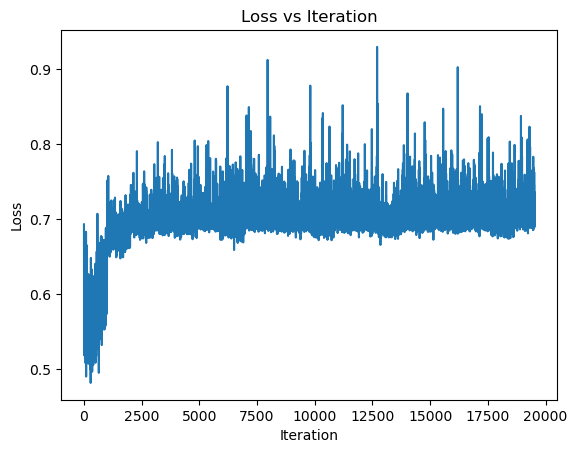

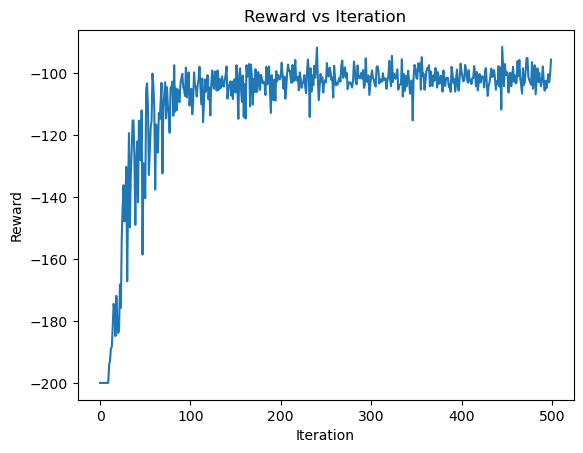

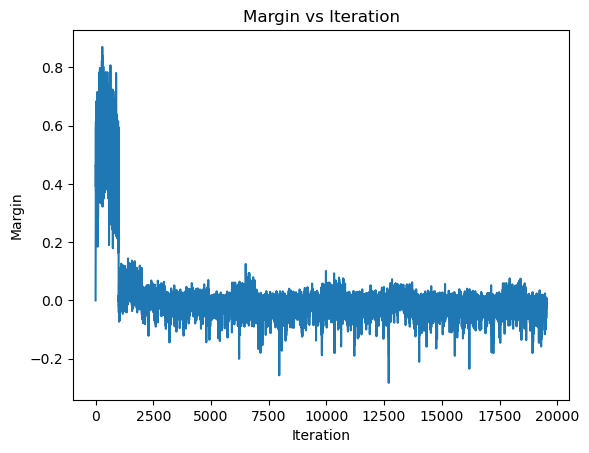

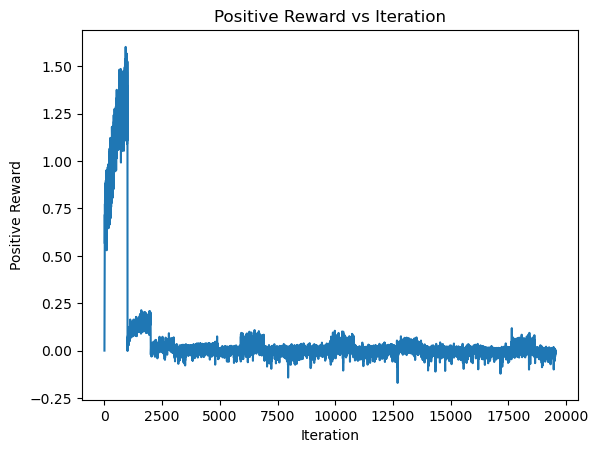

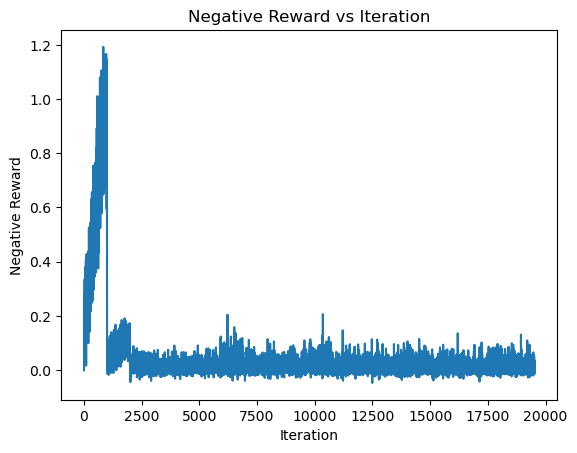

In [12]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./margin.png")
plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")

plt.savefig("./negative_reward.png")
plt.show()
